# Trial Onset ~ all frequencies: LL10

In [50]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra


In [51]:
## Prep paths ##

subject = 'LL10'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

# load preproc functions
%run ../../scripts/preproc_functions.py

In [52]:
## Load Neural Data

# load
trial_onset_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if  x]

# onlt good epochs
trial_onset_epochs = trial_onset_epochs[good_epochs]

Reading /home/brooke/pacman/preprocessing/LL10/ieeg/LL10_bp_clean_pres-locked_ieeg.fif ...


/tmp/ipykernel_232523/973766942.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/LL10/ieeg/LL10_bp_clean_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  trial_onset_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")


    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


In [53]:
## Dictionary of electrode locations ##

# Pull mapping ROI to elecs
%run ../../scripts/roi.py
ROIs = ROIs[subject]

## prep lists

# limbic ROI
hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = [] 
amyg_indices = []
cing_list = []
cing_names = [] 
cing_indices = []
sgACC_list = []
sgACC_names = [] 
sgACC_indices = []
dACC_list = []
dACC_names = [] 
dACC_indices = []
sfg_list = []
sfg_names = [] 
sfg_indices = []
mfg_list = []
mfg_names = [] 
mfg_indices = []

# control ROI
insula_list = []
insula_names = []  
insula_indices = []
dlpfc_list = []
dlpfc_names = []  
dlpfc_indices = []
ec_list = []
ec_names = []  
ec_indices = []

# exclude bad ROI from list
pairs_long_name = [ch.split('-') for ch in trial_onset_epochs.info['ch_names']]
bidx = len(trial_onset_epochs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

# sort ROI into lists
for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
        amyg_indices.append(ix)
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        cing_indices.append(ix)
    if pairs_name[ix][0] in ROIs['sgACC'] or pairs_name[ix][1] in ROIs['sgACC']:
        sgACC_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        sgACC_names.append(pairs_name[ix])
        sgACC_indices.append(ix)
    if pairs_name[ix][0] in ROIs['dACC'] or pairs_name[ix][1] in ROIs['dACC']:
        dACC_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        dACC_names.append(pairs_name[ix])
        dACC_indices.append(ix)        
        
    # control roi
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
        insula_indices.append(ix)
    if pairs_name[ix][0] in ROIs['dlpfc'] or pairs_name[ix][1] in ROIs['dlpfc']:
        dlpfc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        dlpfc_names.append(pairs_name[ix])
        dlpfc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['sfg'] or pairs_name[ix][1] in ROIs['sfg']:
        sfg_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        sfg_names.append(pairs_name[ix])
        sfg_indices.append(ix)   
    if pairs_name[ix][0] in ROIs['mfg'] or pairs_name[ix][1] in ROIs['mfg']:
        mfg_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        mfg_names.append(pairs_name[ix])
        mfg_indices.append(ix)     
    if pairs_name[ix][0] in ROIs['ec'] or pairs_name[ix][1] in ROIs['ec']:
        ec_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        ec_names.append(pairs_name[ix])
        ec_indices.append(ix)        
        

In [54]:
# Print and check frequencies
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)


[  1.           1.06133936   1.12644123   1.19553641   1.26886985
   1.34670151   1.42930732   1.51698011   1.6100307    1.70878895
   1.81360497   1.92485033   2.04291941   2.16823078   2.30122866
   2.44238455   2.59219885   2.75120266   2.91995967   3.09906812
   3.28916297   3.49091812   3.70504879   3.93231411   4.17351973
   4.42952075   4.70122471   4.98959481   5.29565336   5.62048533
   5.96524229   6.33114643   6.71949488   7.13166439   7.5691161
   8.03340082   8.52616447   9.04915393   9.60422322  10.19334011
  10.81859305  11.4821986   12.18650929  12.93402194  13.72738655
  14.56941562  15.46309422  16.4115905   17.41826692  18.48669223
  19.62065406  20.82417239  22.10151375  23.45720642  24.8960564
  26.42316452  28.04394446  29.76414201  31.58985538  33.52755682
  35.58411563  37.76682244  40.08341508  42.54210603  45.1516115
  47.92118237  50.86063693  53.98039574  57.29151856  60.80574353
  64.5355288   68.49409671  72.69548062  77.15457474  81.88718682
  86.91009428

# Main Regions of Interest

## Hippocampus

In [55]:
hc_list

['RH1-RH2', 'RH2-RH3', 'LH1-LH2', 'LH2-LH3']

In [56]:
# only ROI of interest
trial_onset_roi = trial_onset_epochs.copy().pick_channels(hc_list)


In [57]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [58]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = compute_TFR(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:   35.4s remaining:   35.4s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:   42.1s finished


Not setting metadata


In [59]:
# Crop to time of interest

roi_pres_TFR.crop(tmin = -1, tmax = 5)

<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 200.000000], epochs : 211, channels : 4, ~1.74 GB>

In [60]:
# save TFRs

roi_pres_TFR.save(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/trial_onset/hc-tfr.h5", overwrite = True)

In [61]:
# Log and zscore

roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,5), logflag=True)

log transforming
z-scoring to baseline


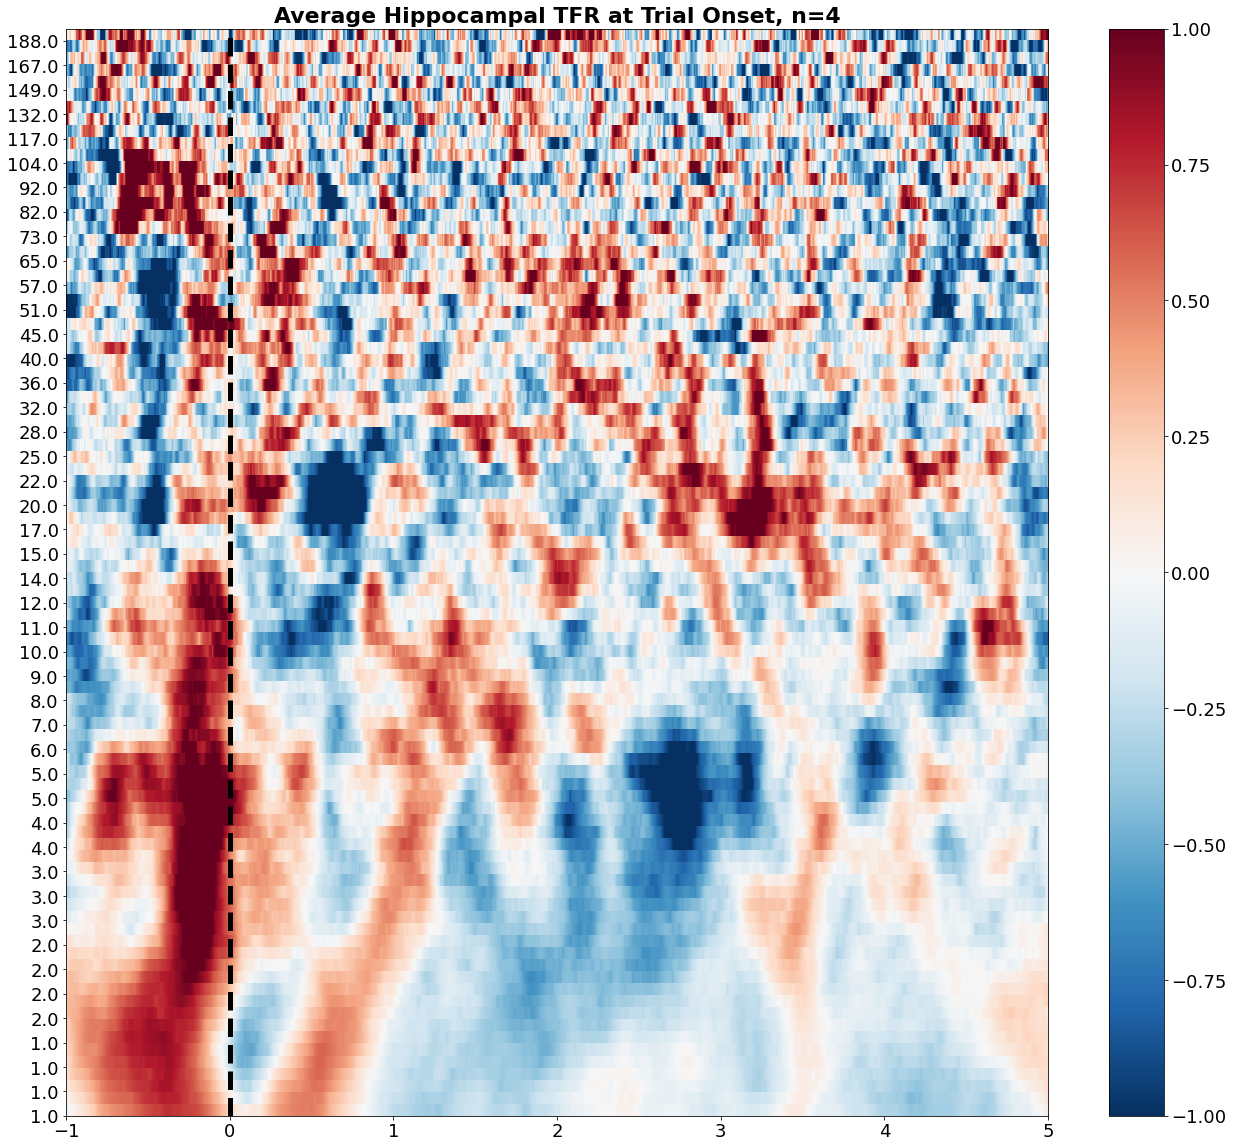

In [62]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -1, vmax = 1)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs))[::2])
ax.set_yticklabels(np.round(roi_pres_TFR.freqs)[::2]) 
i2 = plt.axvline(x=0, color='black', linestyle='--', linewidth = 5)
bar = plt.colorbar(i)
ax.set_title(f"Average Hippocampal TFR at Trial Onset, n={len(hc_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


## Individual Channels

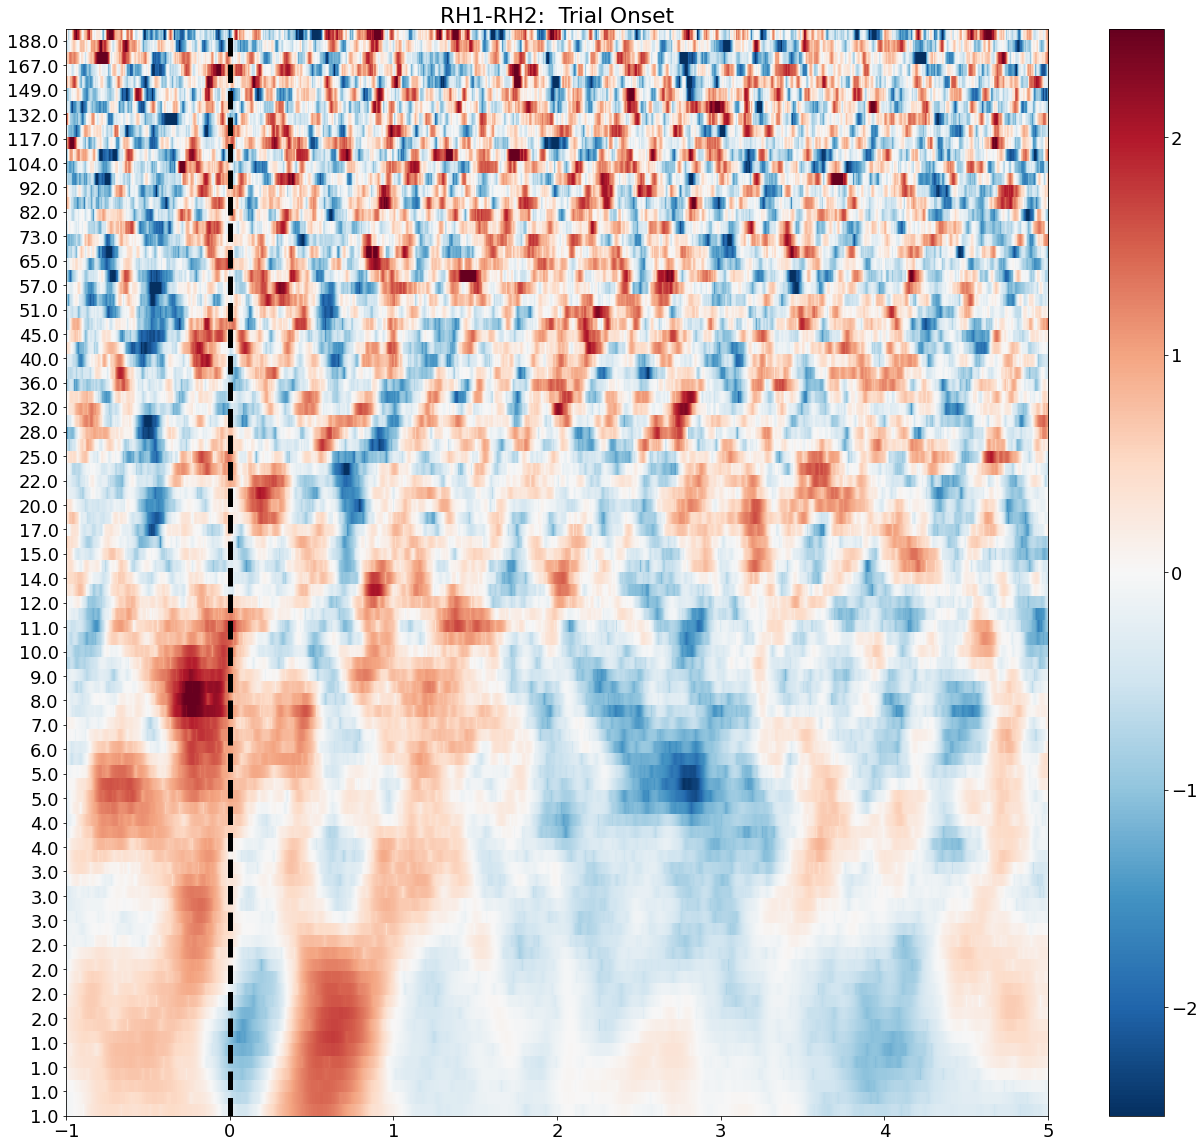

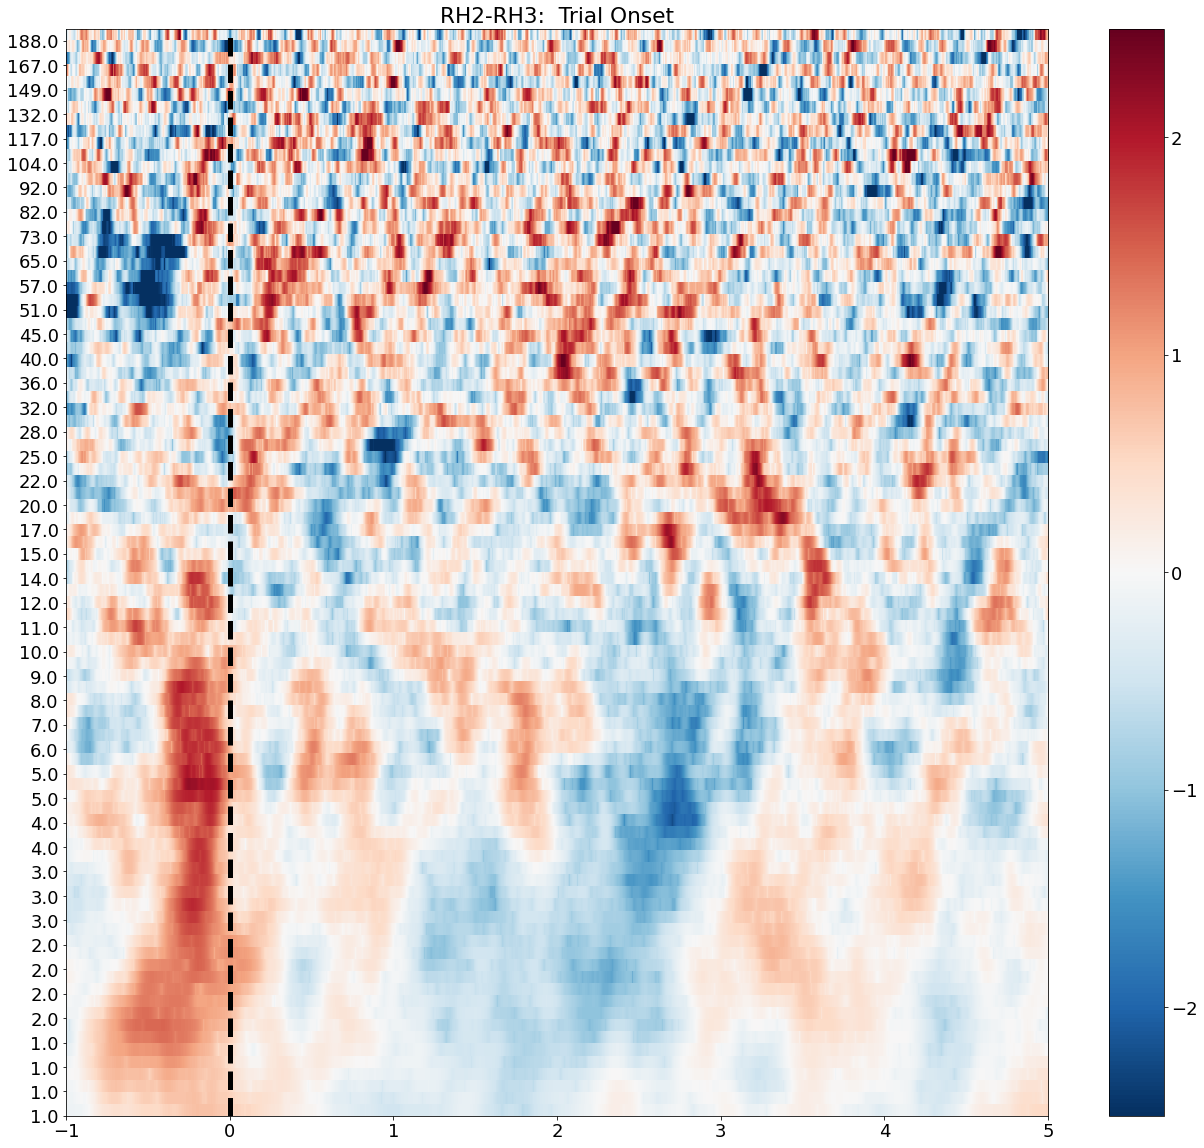

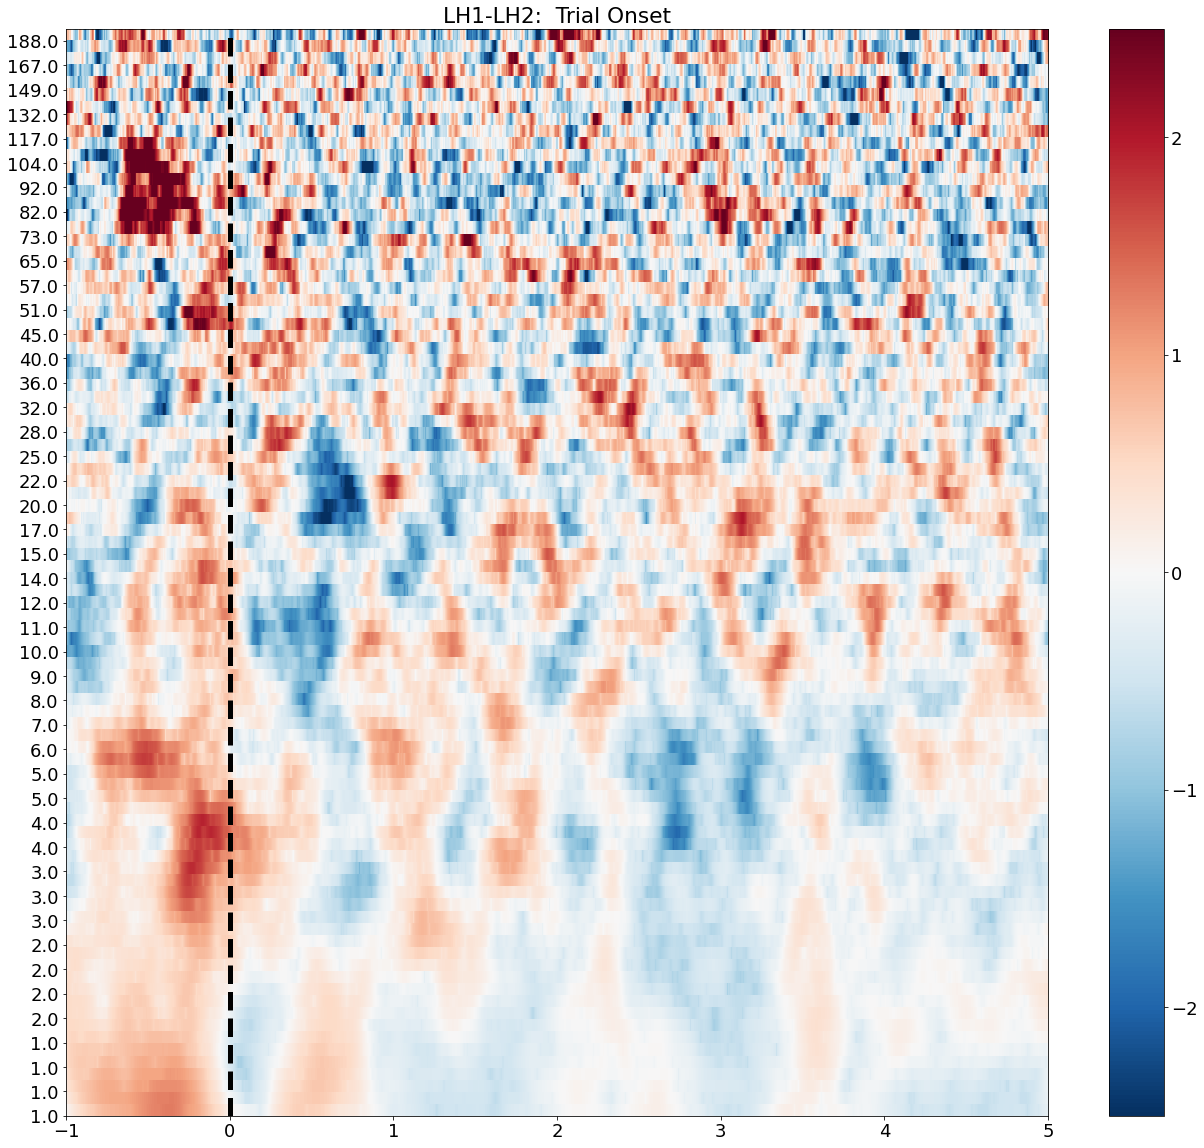

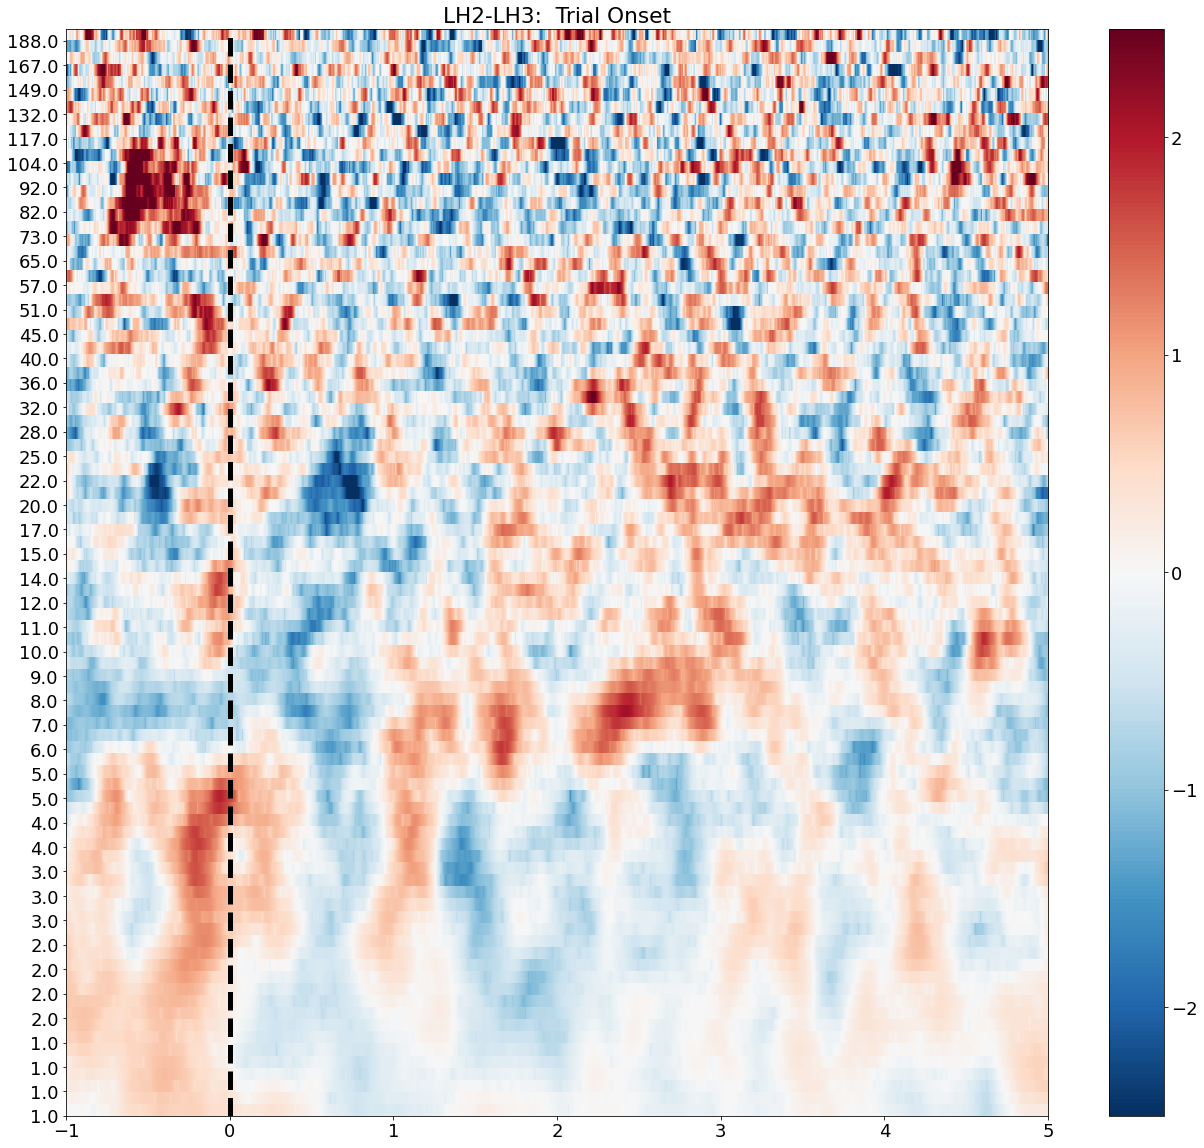

In [63]:
plt.rcParams['figure.figsize'] = [22, 20]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots(figsize = (22, 20))
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -2.5, vmax = 2.5)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs))[::2])
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs)[::2]) 
    bar = plt.colorbar(i)
    i2 = plt.axvline(x=0, color='black', linestyle='--', linewidth = 5)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()

    
    chix = chix + 1

## Export freq data locked to turn around time to csvs

# OFC

In [64]:
ofc_list

['ROF1-ROF2']

In [65]:
# only roi of interest
trial_onset_roi = trial_onset_epochs.copy().pick_channels(ofc_list)


In [66]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [67]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = compute_TFR(trial_onset_roi,freqs,n_cycles)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Not setting metadata


In [68]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 200.000000], epochs : 211, channels : 1, ~445.2 MB>

In [69]:
# save TFRs

roi_pres_TFR.save(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/trial_onset/ofc-tfr.h5", overwrite = True)

In [70]:
# Log and zscore

roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,5), logflag=True)

log transforming
z-scoring to baseline


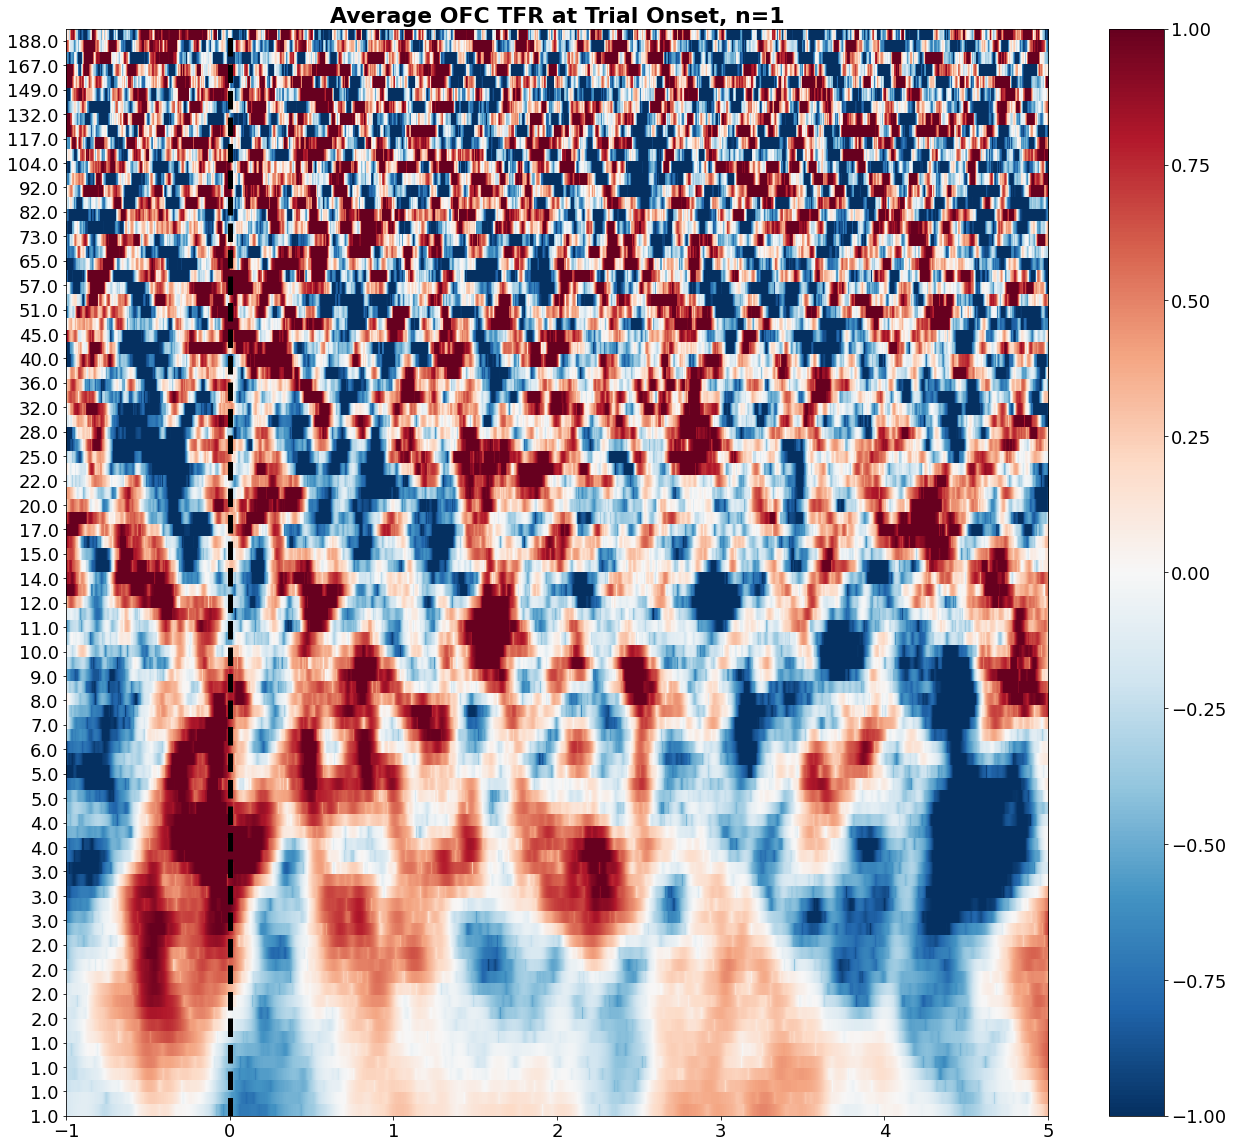

In [71]:
plt.rcParams['figure.figsize'] = [22, 20]

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -1, vmax = 1)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs))[::2])
ax.set_yticklabels(np.round(roi_pres_TFR.freqs)[::2]) 
i2 = plt.axvline(x=0, color='black', linestyle='--', linewidth = 5)
bar = plt.colorbar(i)
ax.set_title(f"Average OFC TFR at Trial Onset, n={len(ofc_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'figures/{subject}_average_ofc_trialonset.png', dpi=600)
fig.show()


### Individual Channels

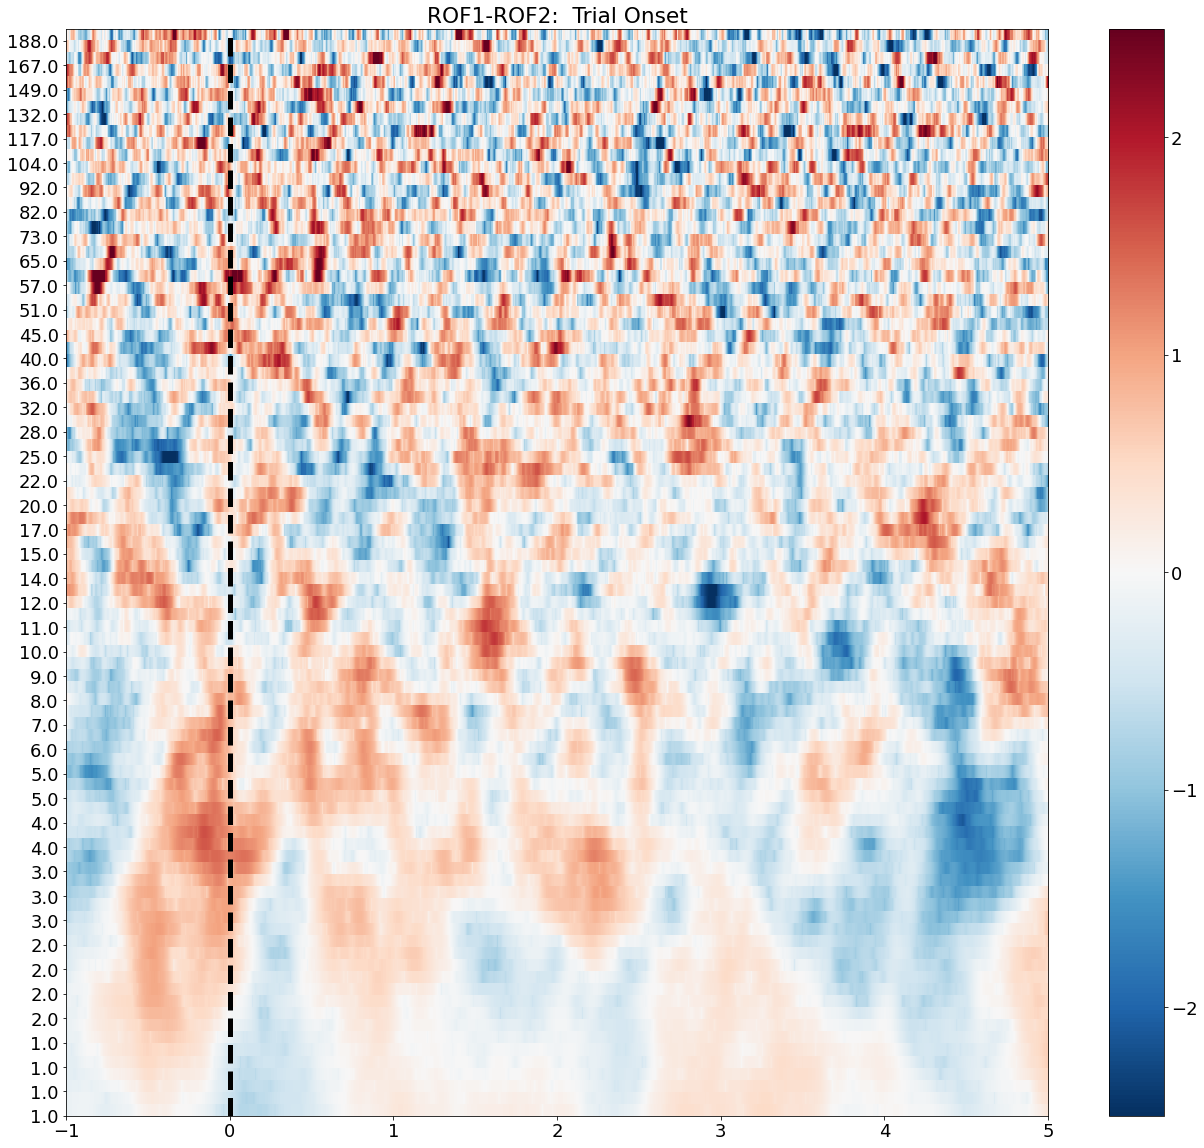

In [72]:
plt.rcParams['figure.figsize'] = [22, 20]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots(figsize = (22, 20))
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -2.5, vmax = 2.5)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs))[::2])
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs)[::2]) 
    i2 = plt.axvline(x=0, color='black', linestyle='--', linewidth = 5)
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()
    
    chix = chix + 1

# Amygdala

In [73]:
amyg_list

['RA2-RA3']

In [74]:
# only roi 
trial_onset_roi = trial_onset_epochs.copy().pick_channels(amyg_list)


In [75]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [76]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = compute_TFR(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Not setting metadata


In [77]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 200.000000], epochs : 211, channels : 1, ~445.2 MB>

In [78]:
# save TFRs

roi_pres_TFR.save(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/trial_onset/amyg-tfr.h5", overwrite = True)

In [79]:
# Log and zscore

roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,5), logflag=True)

log transforming
z-scoring to baseline


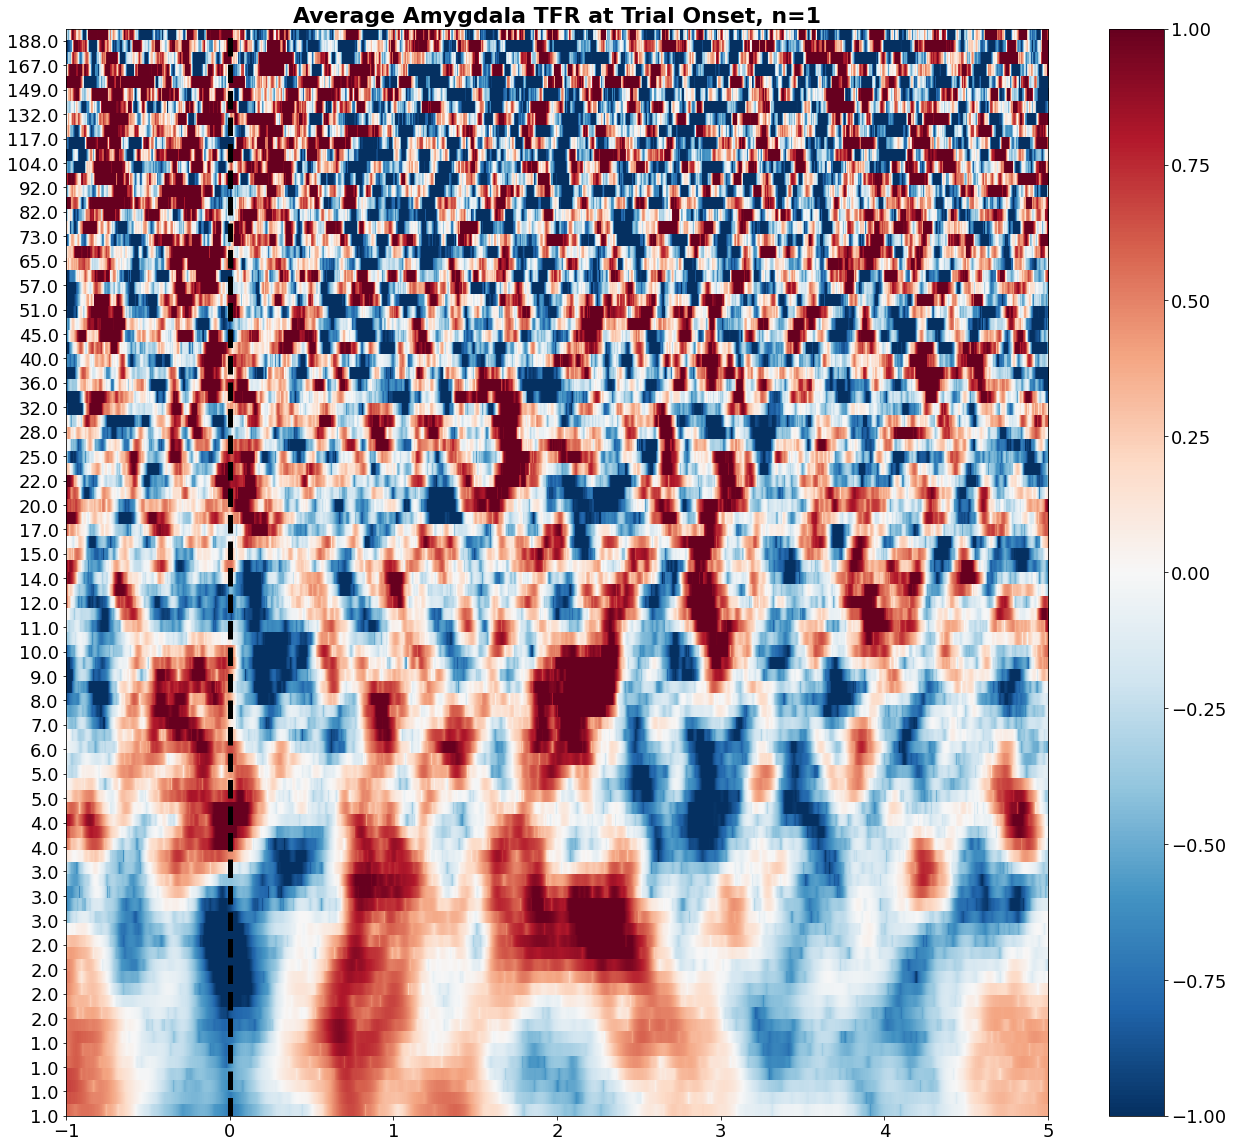

In [80]:
plt.rcParams['figure.figsize'] = [22, 20]

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin =-1, vmax = 1)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs))[::2])
ax.set_yticklabels(np.round(roi_pres_TFR.freqs)[::2]) 
i2 = plt.axvline(x=0, color='black', linestyle='--', linewidth = 5)
bar = plt.colorbar(i)
ax.set_title(f"Average Amygdala TFR at Trial Onset, n={len(amyg_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'figures/{subject}_average_amyg_trialonset.png', dpi=600)
fig.show()


### Individual Channels

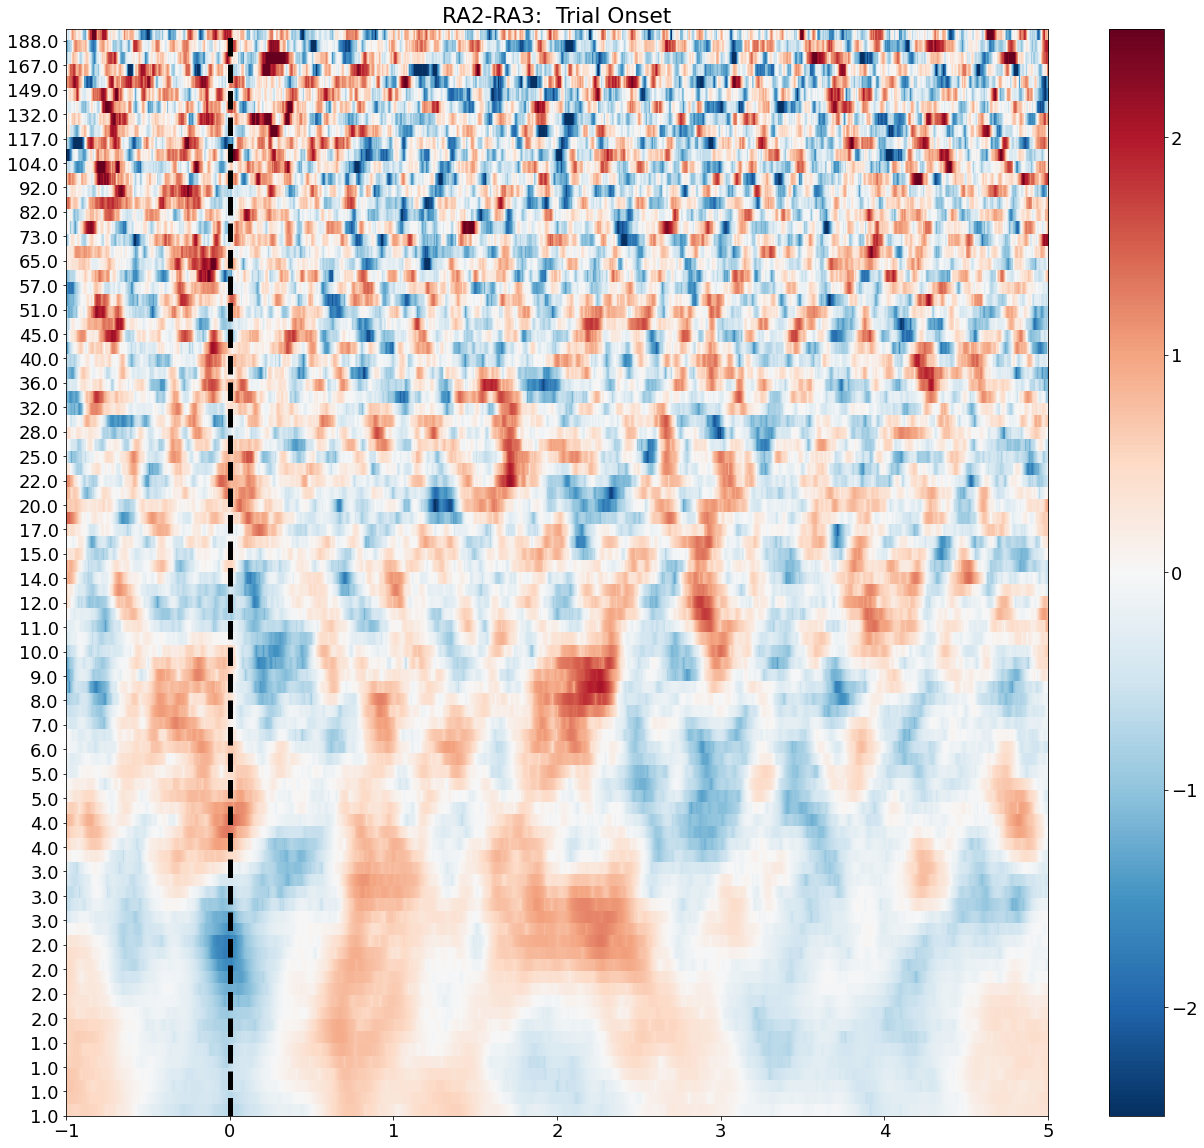

In [81]:
plt.rcParams['figure.figsize'] = [22, 20]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots(figsize = (22, 20))
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -2.5, vmax = 2.5)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs))[::2])
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs)[::2]) 
    i2 = plt.axvline(x=0, color='black', linestyle='--', linewidth = 5)
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()
    
    chix = chix + 1

## Cingulate

In [82]:
cing_list

['RAC1-RAC2', 'RAC2-RAC3', 'RAC3-RAC4', 'LOF1-LOF2', 'LAC1-LAC2', 'LAC2-LAC3']

In [83]:
# only roi 
trial_onset_roi = trial_onset_epochs.copy().pick_channels(cing_list)


In [84]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [85]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = compute_TFR(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   6 | elapsed:   42.5s remaining:   42.5s
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:   52.5s finished


Not setting metadata


In [86]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 200.000000], epochs : 211, channels : 6, ~2.61 GB>

In [87]:
# save TFRs

roi_pres_TFR.save(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/trial_onset/cing-tfr.h5", overwrite = True)

In [88]:
# Log and zscore

roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,5), logflag=True)

log transforming
z-scoring to baseline


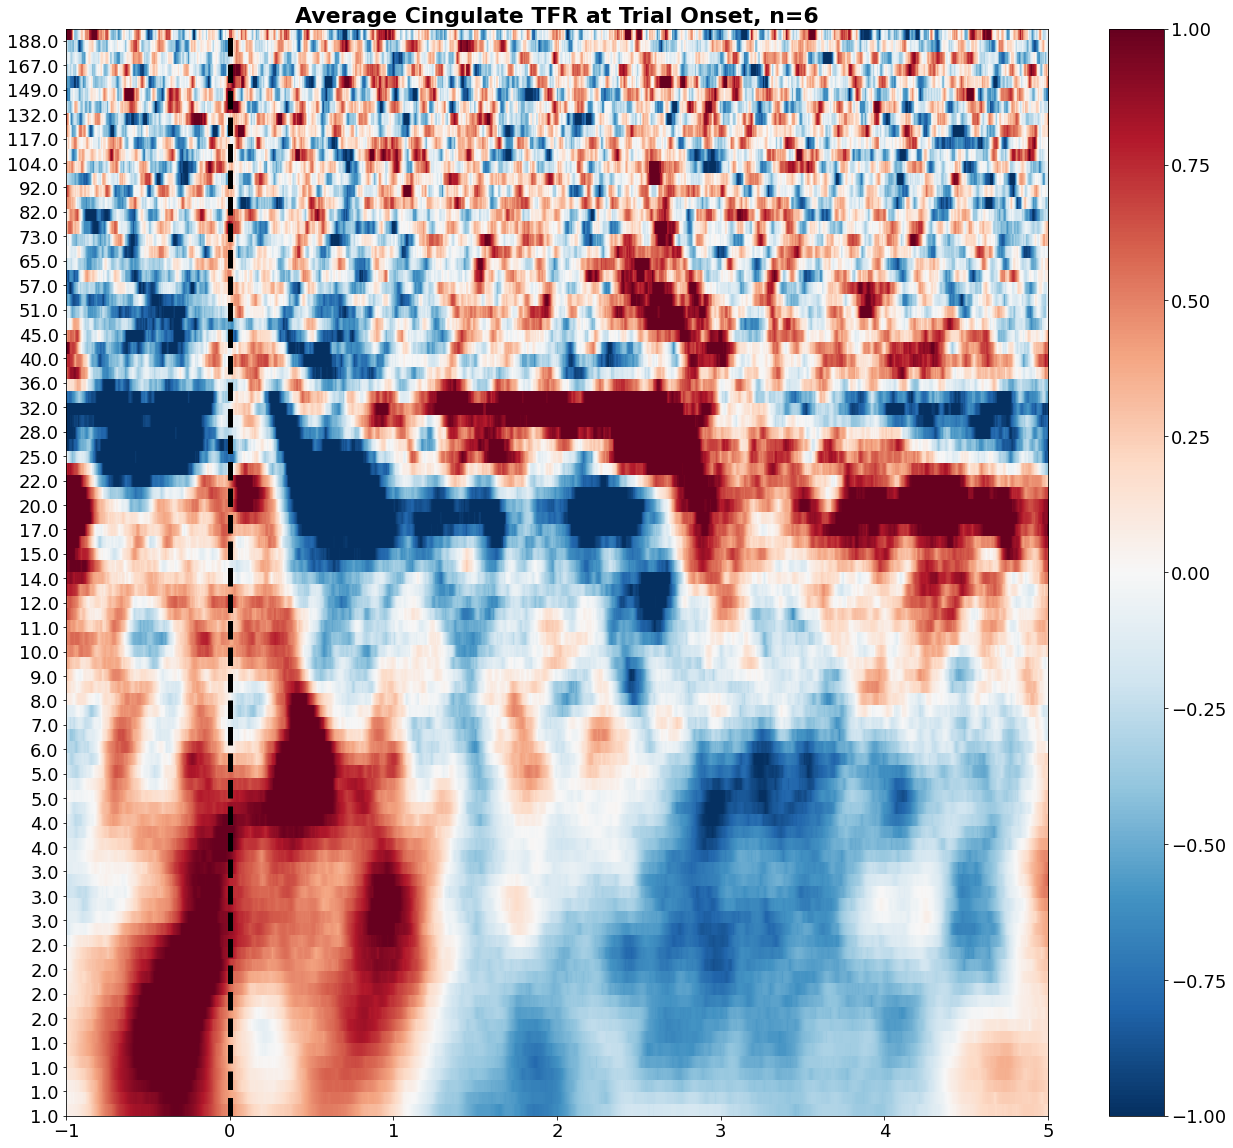

In [89]:
plt.rcParams['figure.figsize'] = [22, 20]

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin =-1, vmax = 1)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs))[::2])
ax.set_yticklabels(np.round(roi_pres_TFR.freqs)[::2]) 
i2 = plt.axvline(x=0, color='black', linestyle='--', linewidth = 5)
bar = plt.colorbar(i)
ax.set_title(f"Average Cingulate TFR at Trial Onset, n={len(cing_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'figures/{subject}_average_cing_trialonset.png', dpi=600)
fig.show()


### Individual Channels

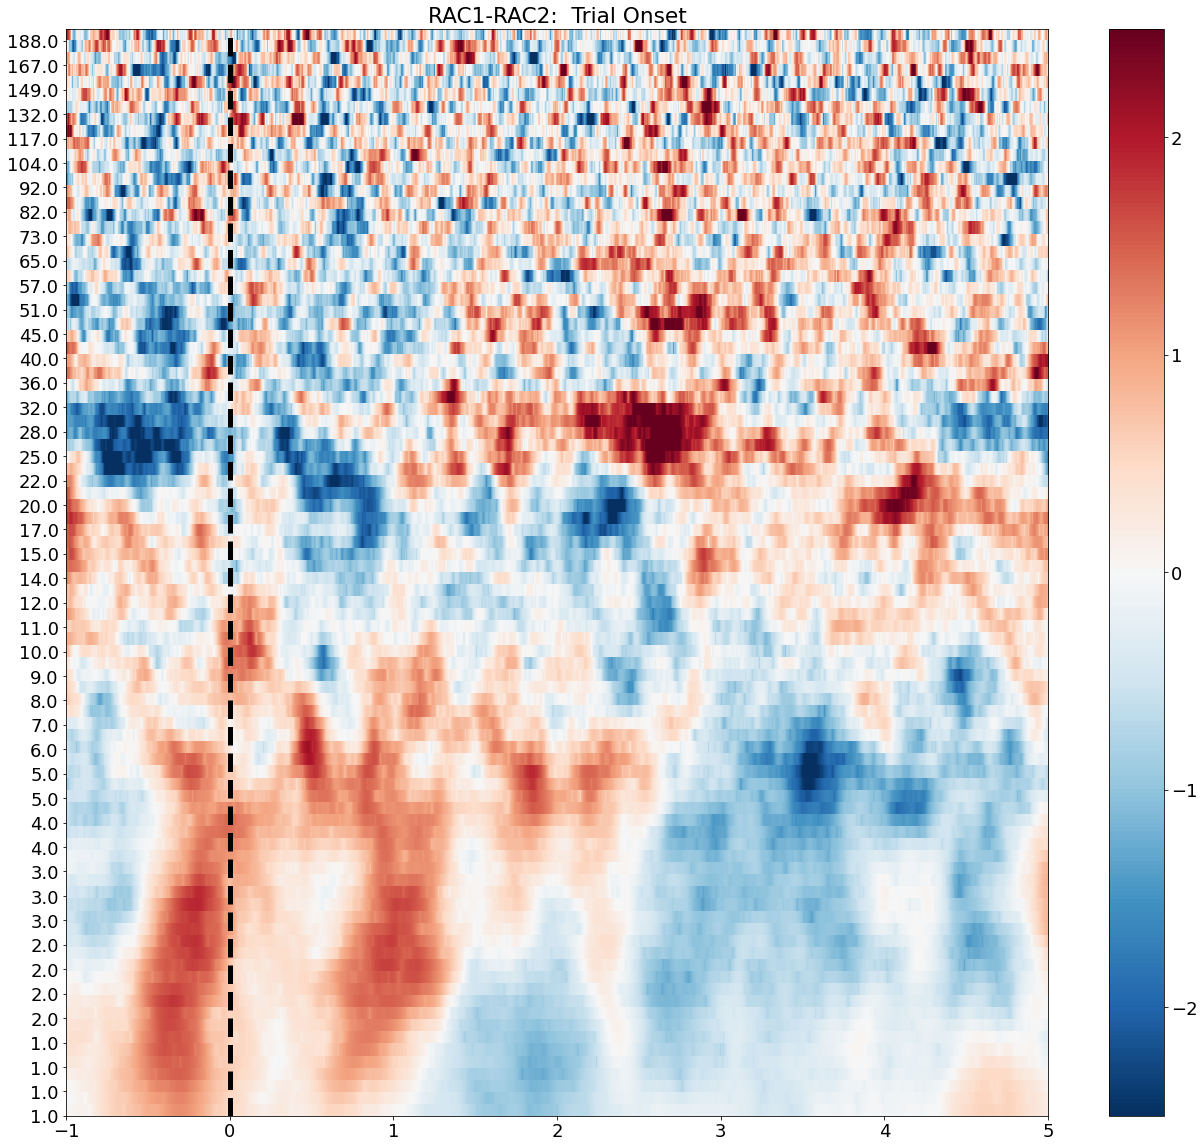

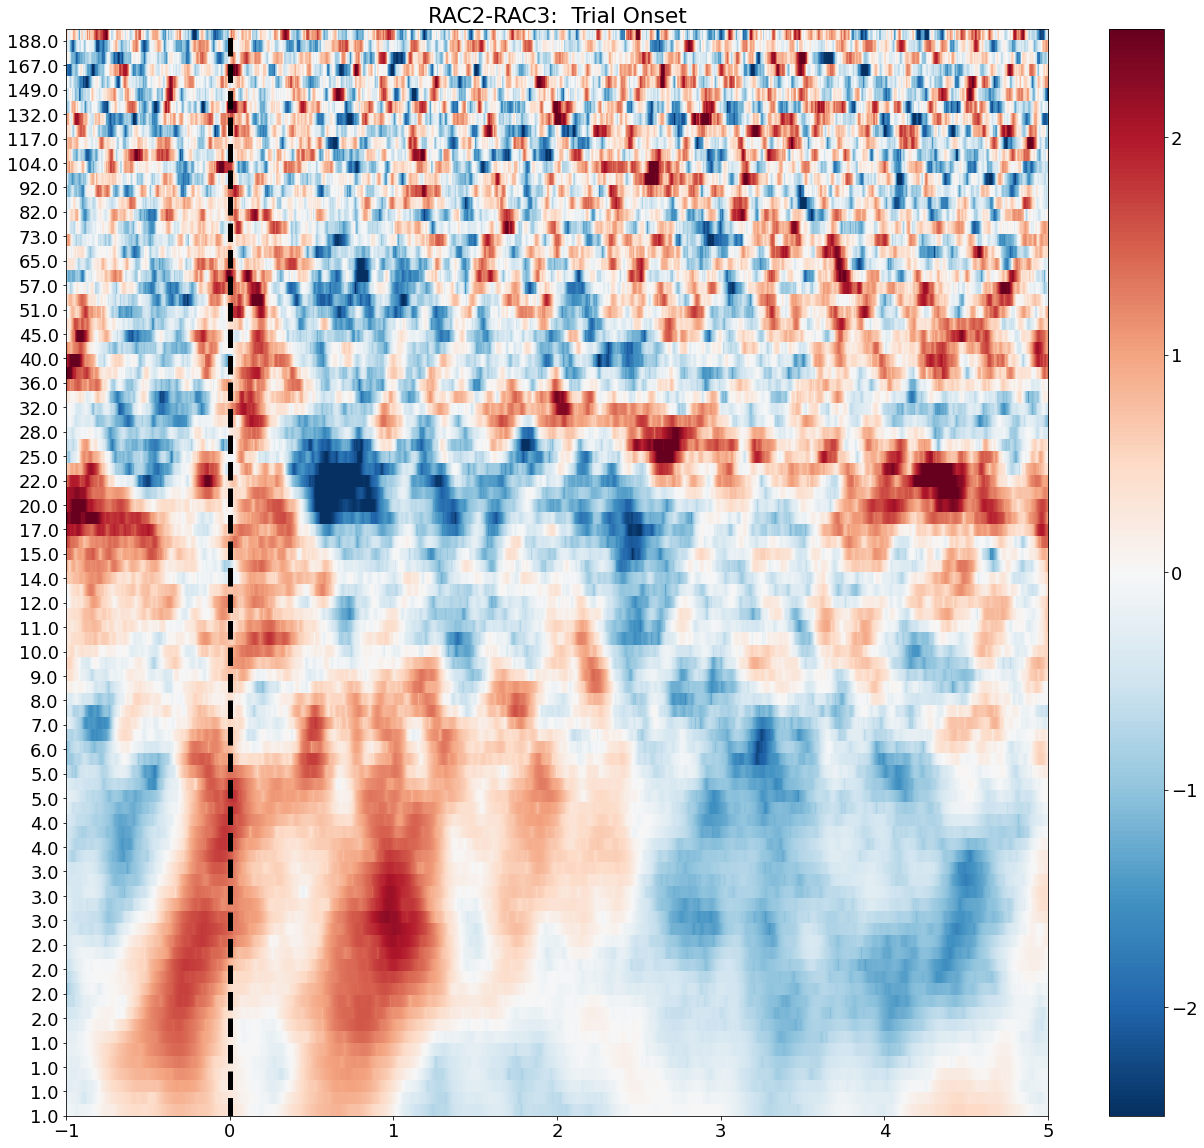

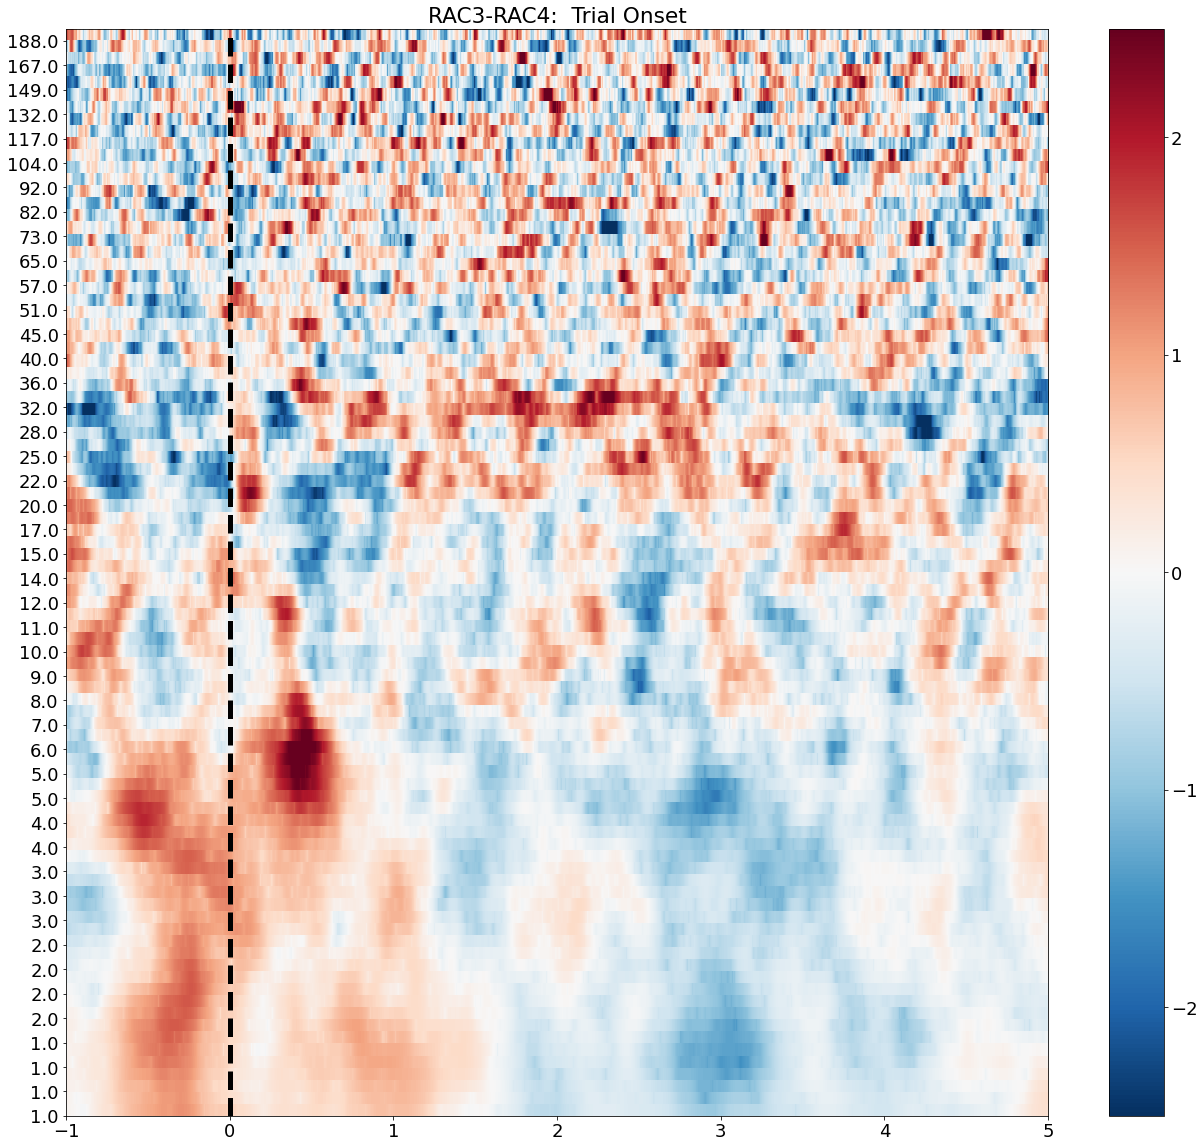

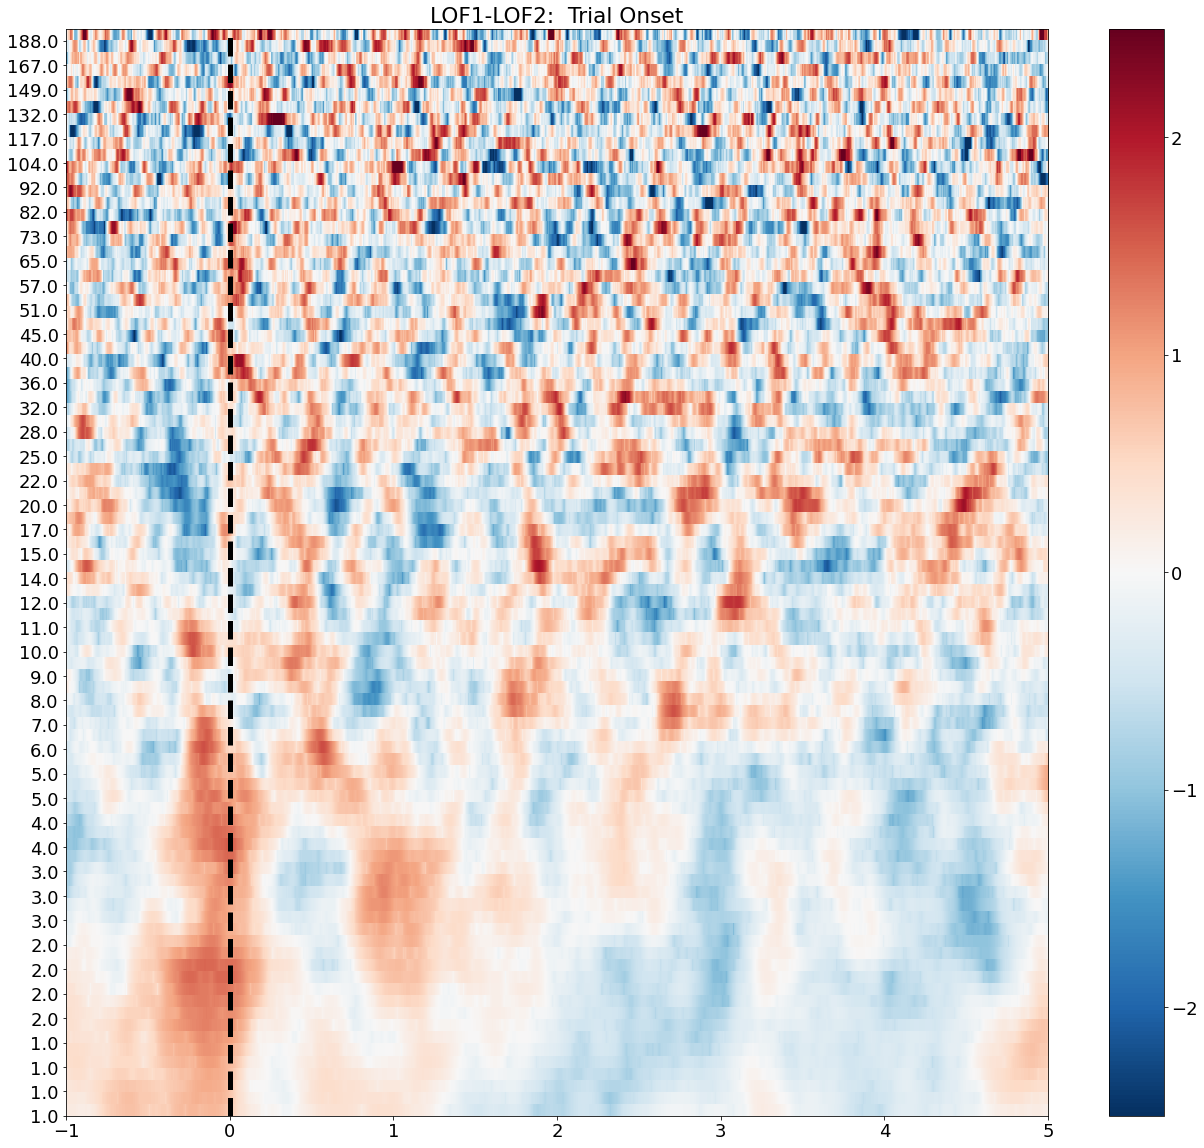

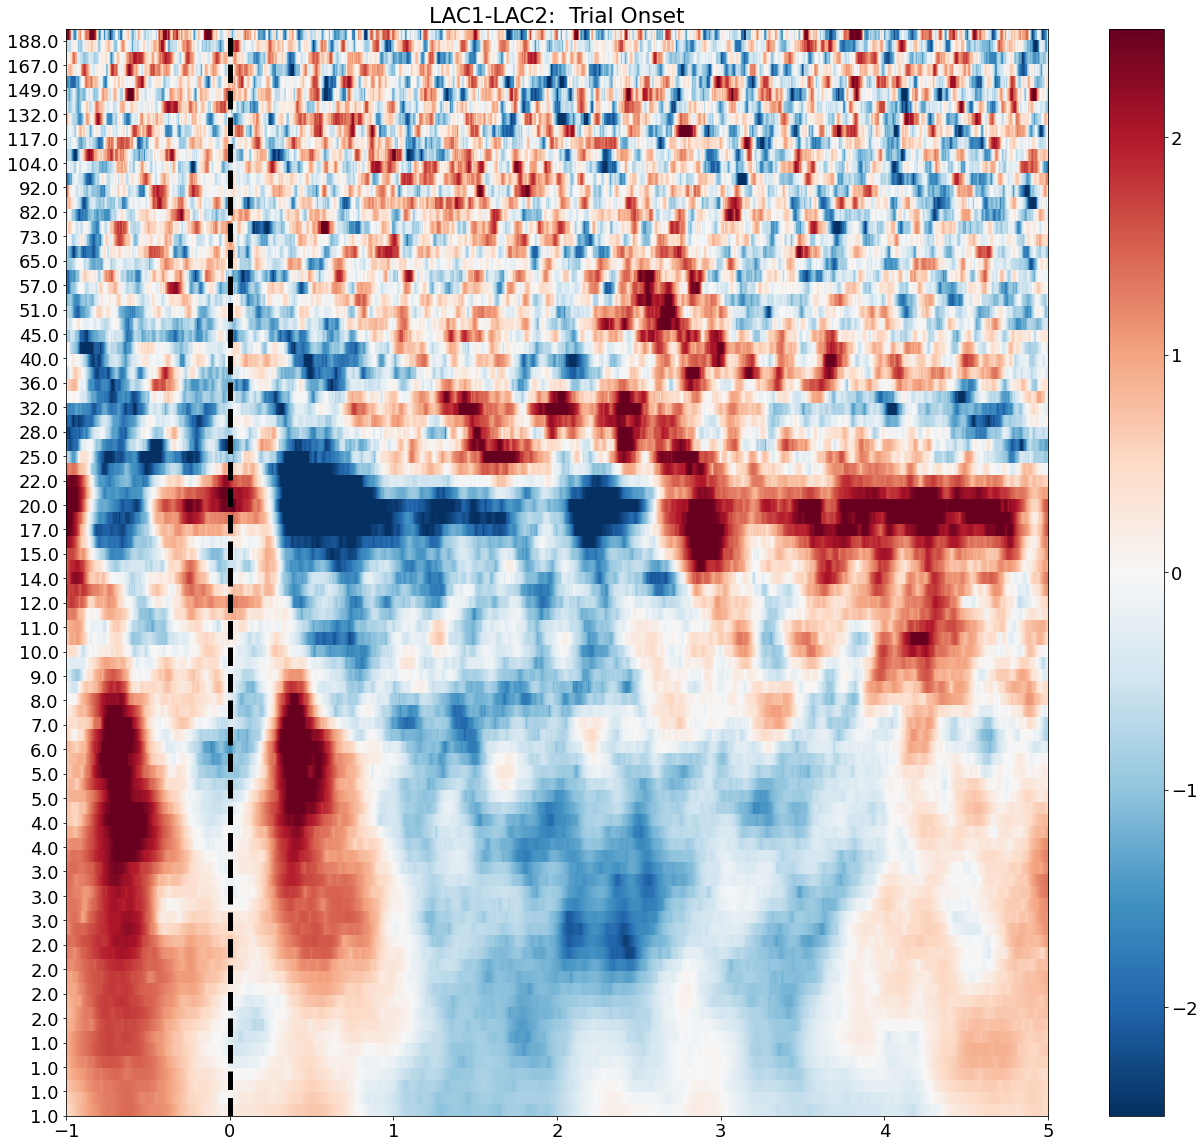

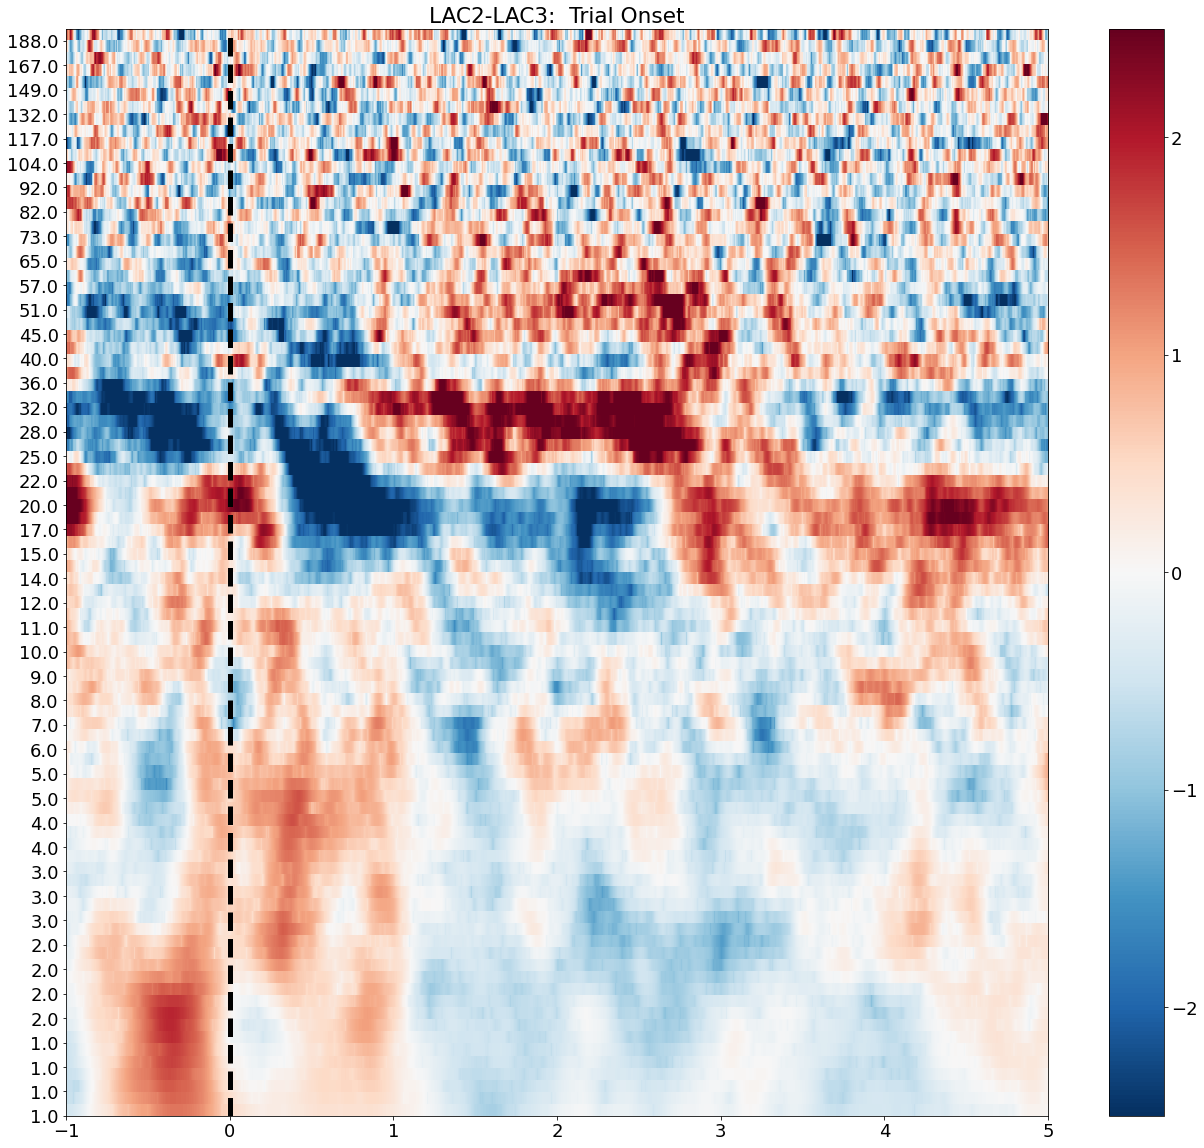

In [90]:
plt.rcParams['figure.figsize'] = [22, 20]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots(figsize = (22, 20))
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -2.5, vmax = 2.5)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs))[::2])
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs)[::2]) 
    i2 = plt.axvline(x=0, color='black', linestyle='--', linewidth = 5)
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()

    chix = chix + 1

# Control Regions

## dlPFC

In [91]:
dlpfc_list

['ROF9-ROF10',
 'RAC5-RAC6',
 'RAC6-RAC7',
 'LOF7-LOF8',
 'LOF8-LOF9',
 'LOF9-LOF10',
 'LAC4-LAC5',
 'LAC5-LAC6',
 'LAC6-LAC7',
 'LAC7-LAC8']

In [92]:
# Only ROI
trial_onset_roi = trial_onset_epochs.copy().pick_channels(dlpfc_list)


In [93]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [94]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = compute_TFR(trial_onset_roi,freqs,n_cycles)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:  1.0min remaining:   41.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.3min finished


Not setting metadata


In [95]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 200.000000], epochs : 211, channels : 10, ~4.35 GB>

In [96]:
# save TFRs

roi_pres_TFR.save(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/trial_onset/dlpfc-tfr.h5", overwrite = True)

In [97]:
# Log and zscore

roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,5), logflag=True)

log transforming
z-scoring to baseline


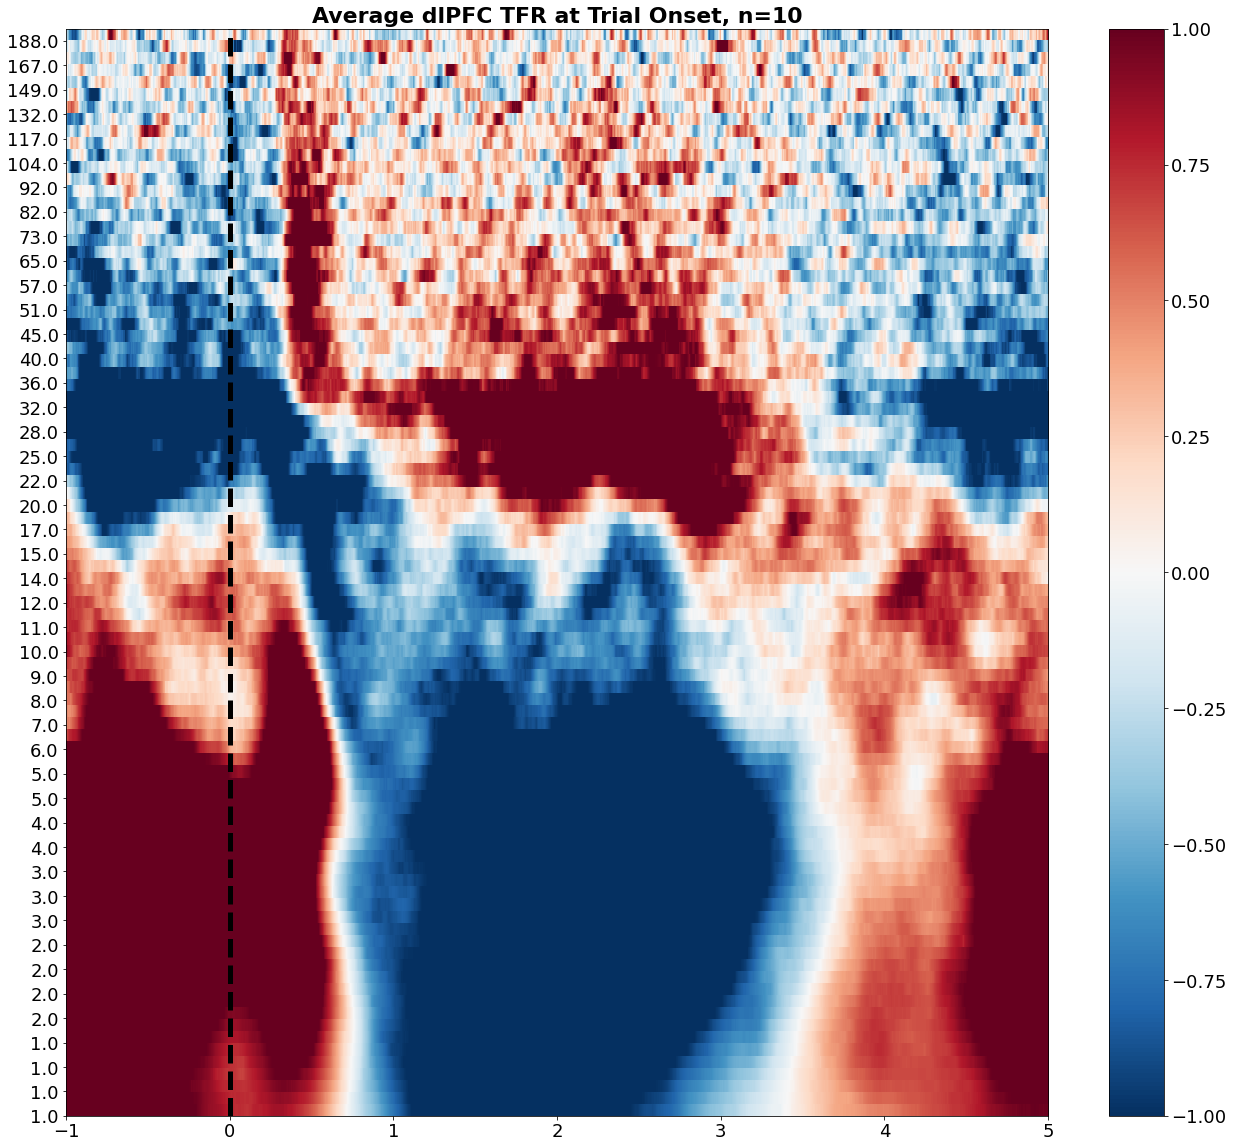

In [98]:
plt.rcParams['figure.figsize'] = [15, 11]

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin =-1, vmax = 1)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs))[::2])
ax.set_yticklabels(np.round(roi_pres_TFR.freqs)[::2]) 
i2 = plt.axvline(x=0, color='black', linestyle='--', linewidth = 5)
bar = plt.colorbar(i)
ax.set_title(f"Average dlPFC TFR at Trial Onset, n={len(dlpfc_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'figures/{subject}_average_dlpfc_trialonset.png', dpi=600)
fig.show()


### Individual Channels

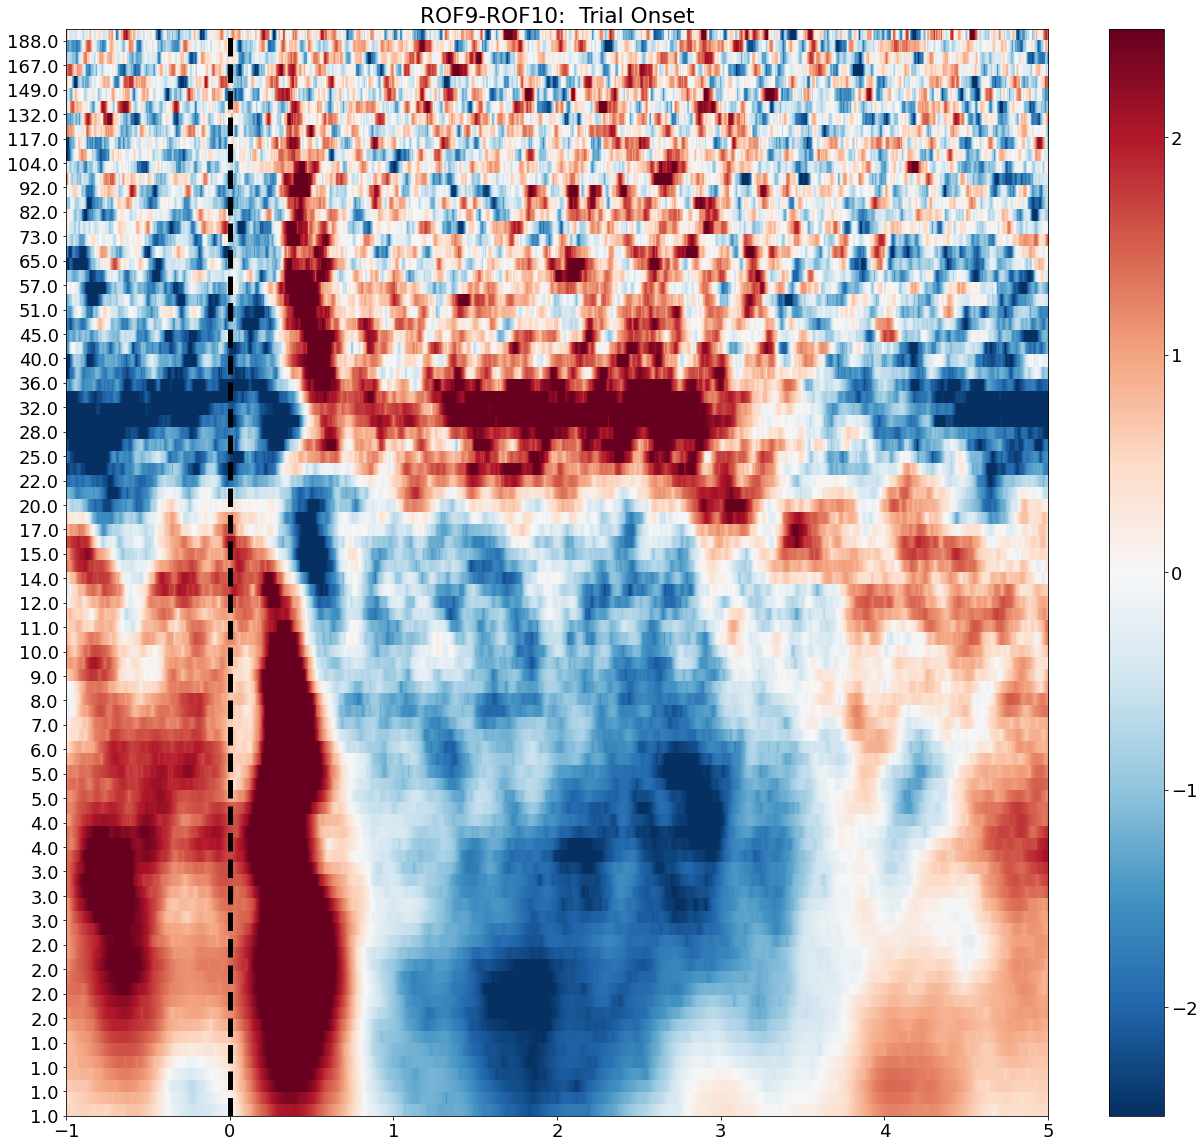

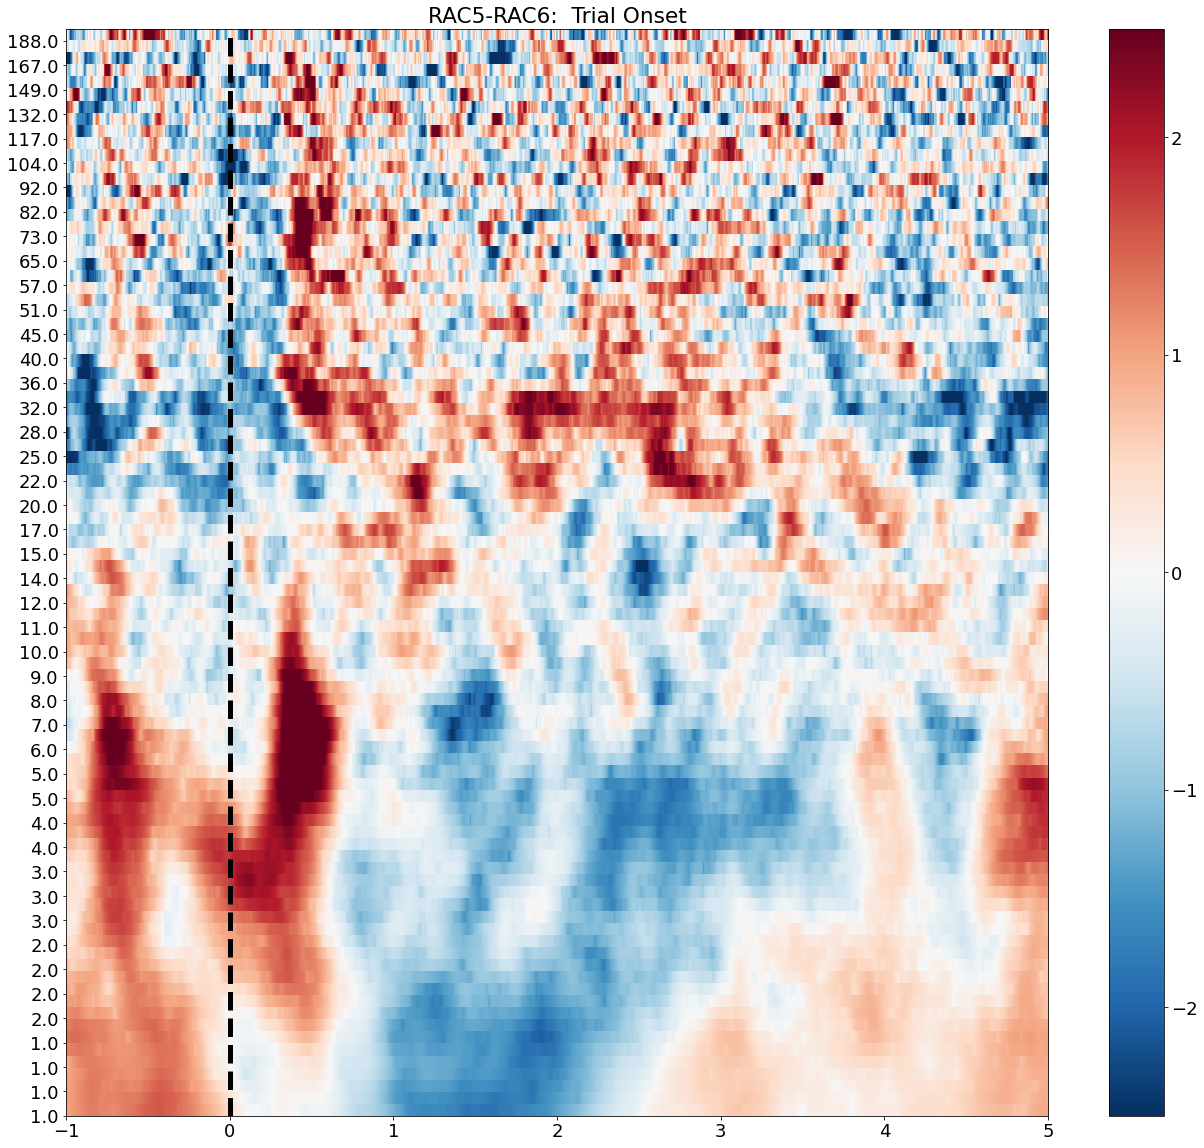

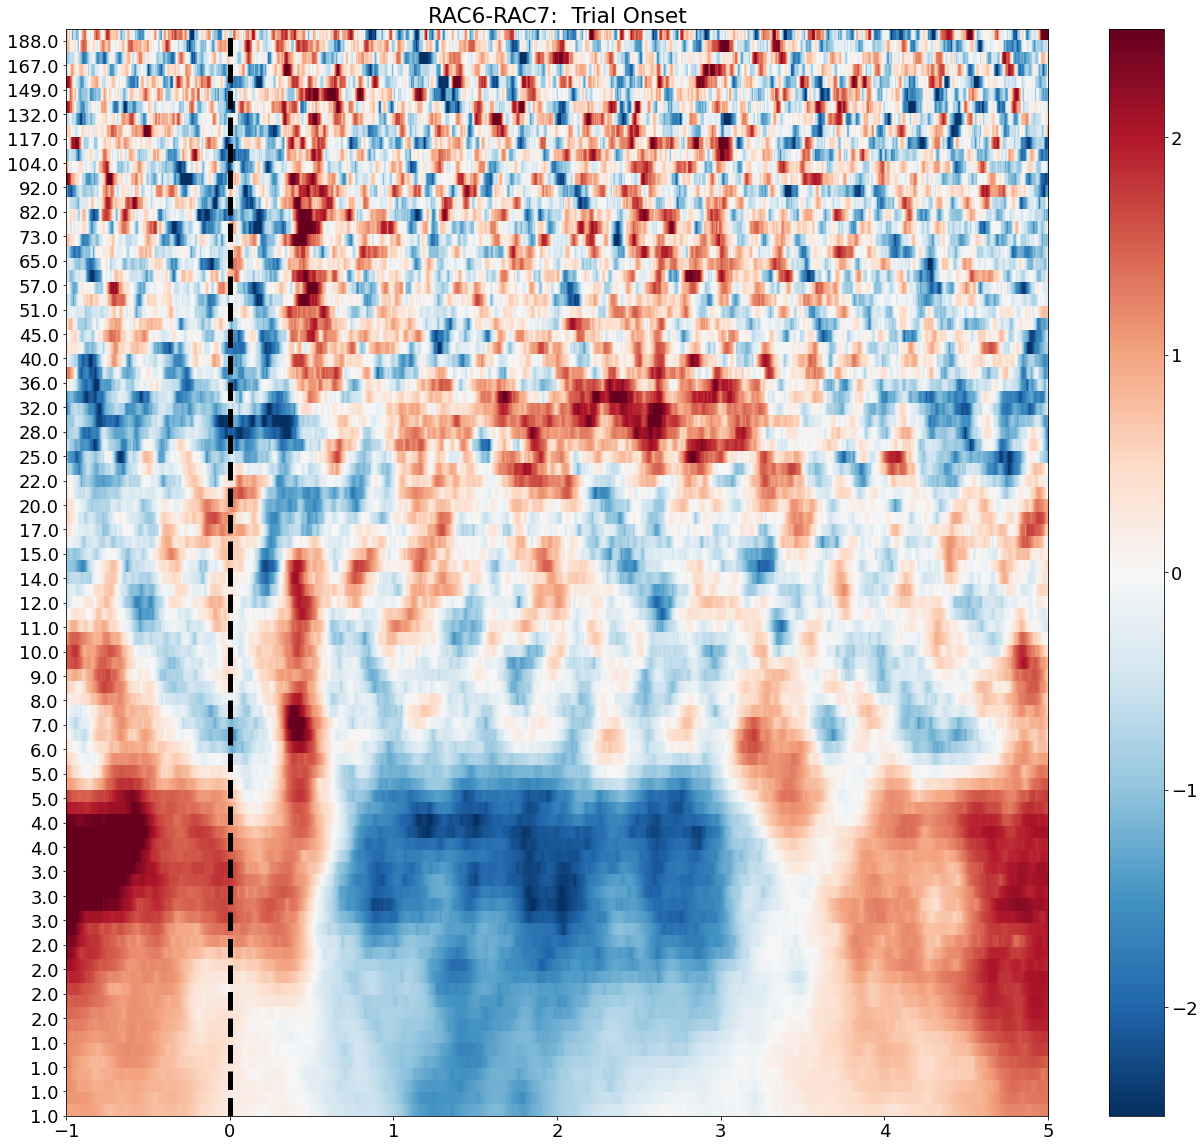

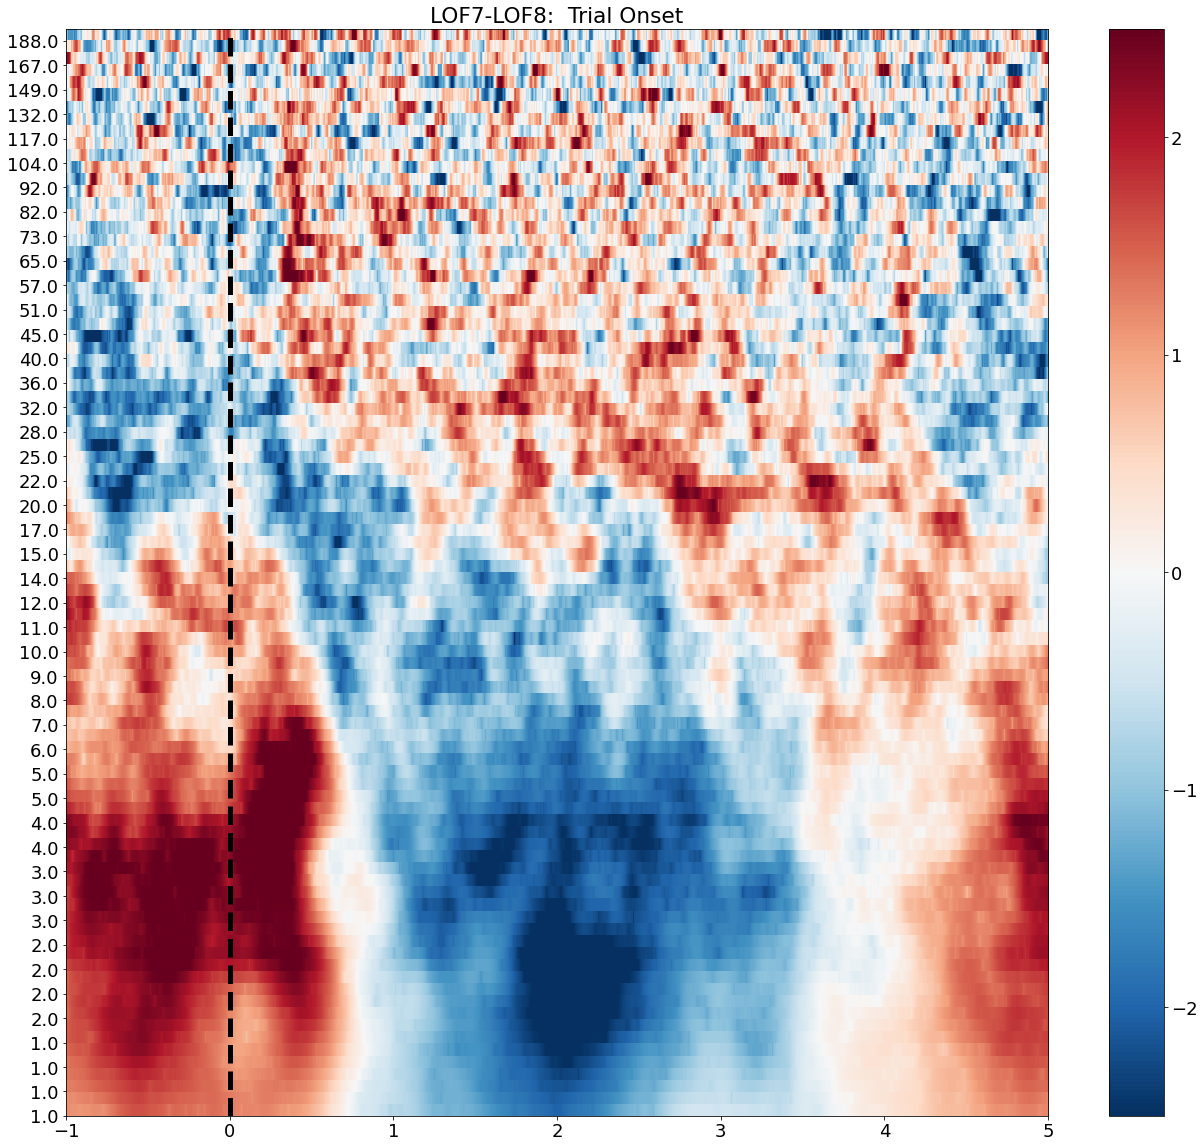

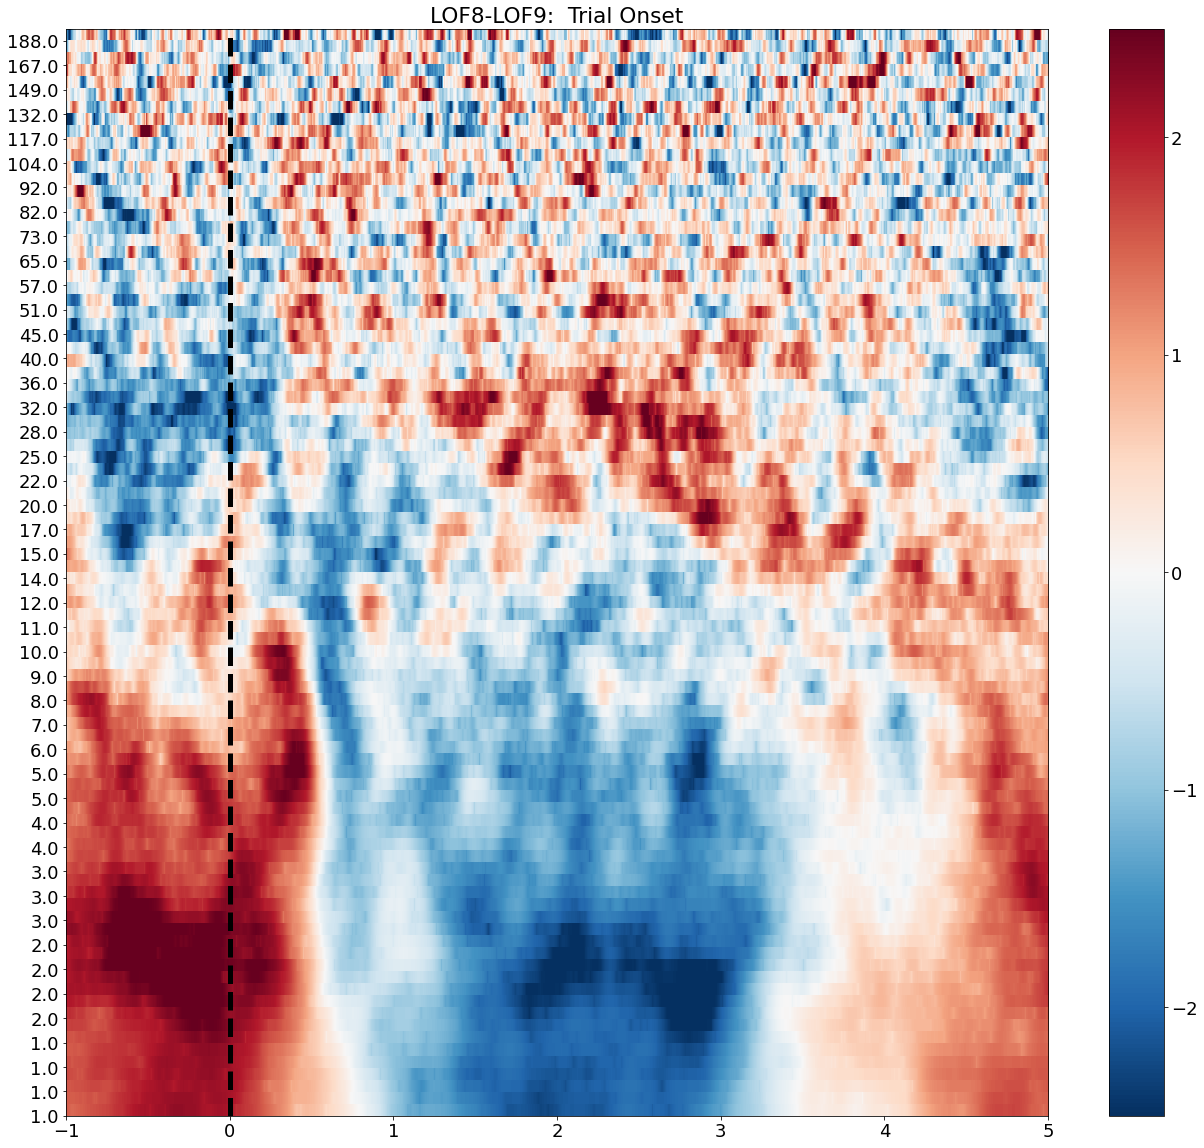

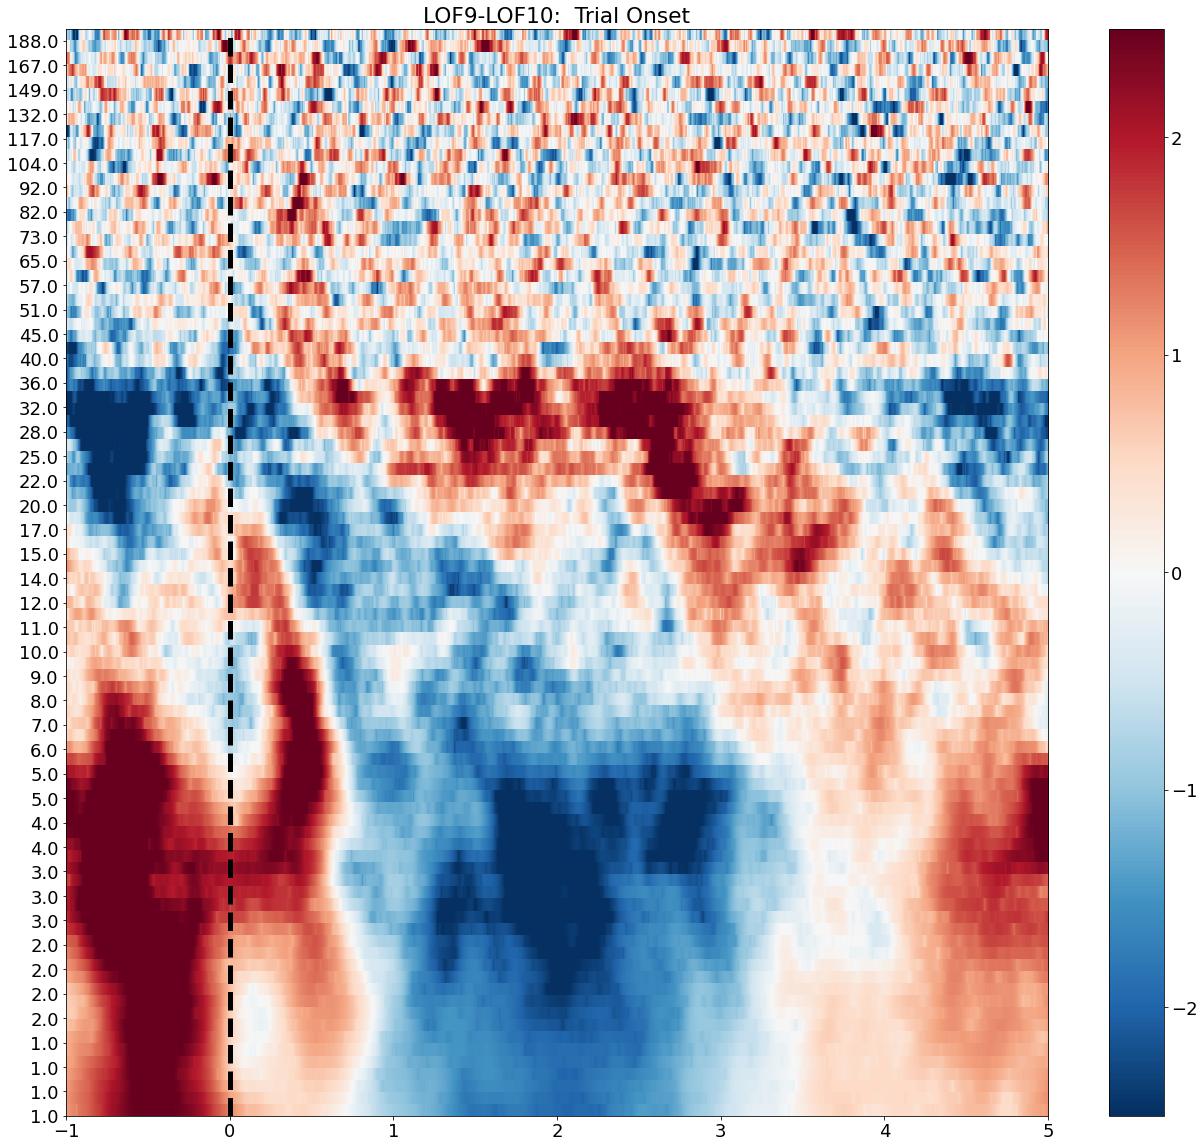

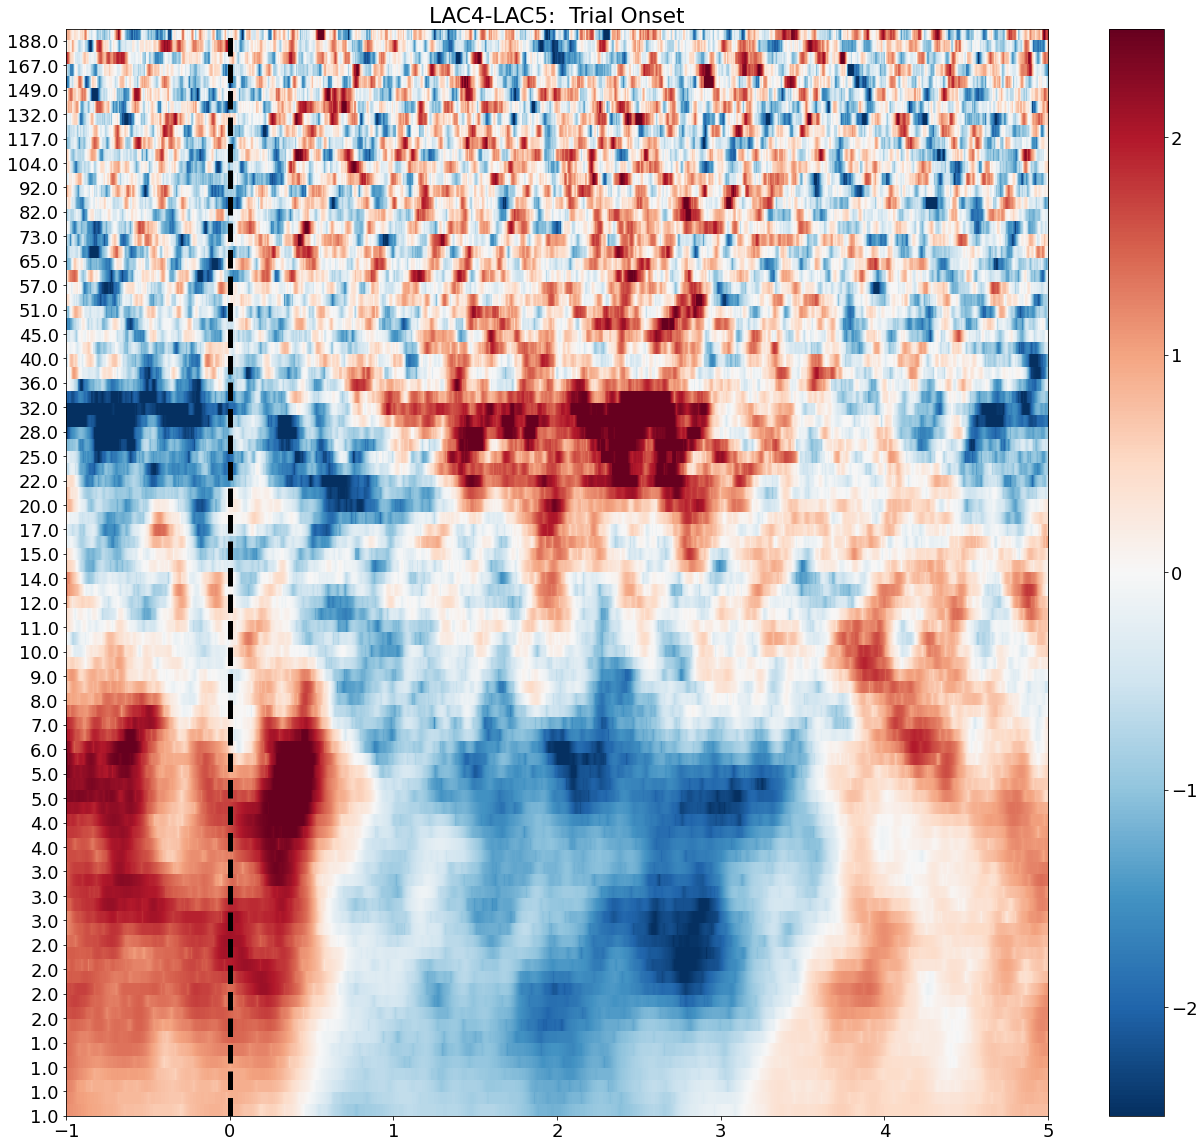

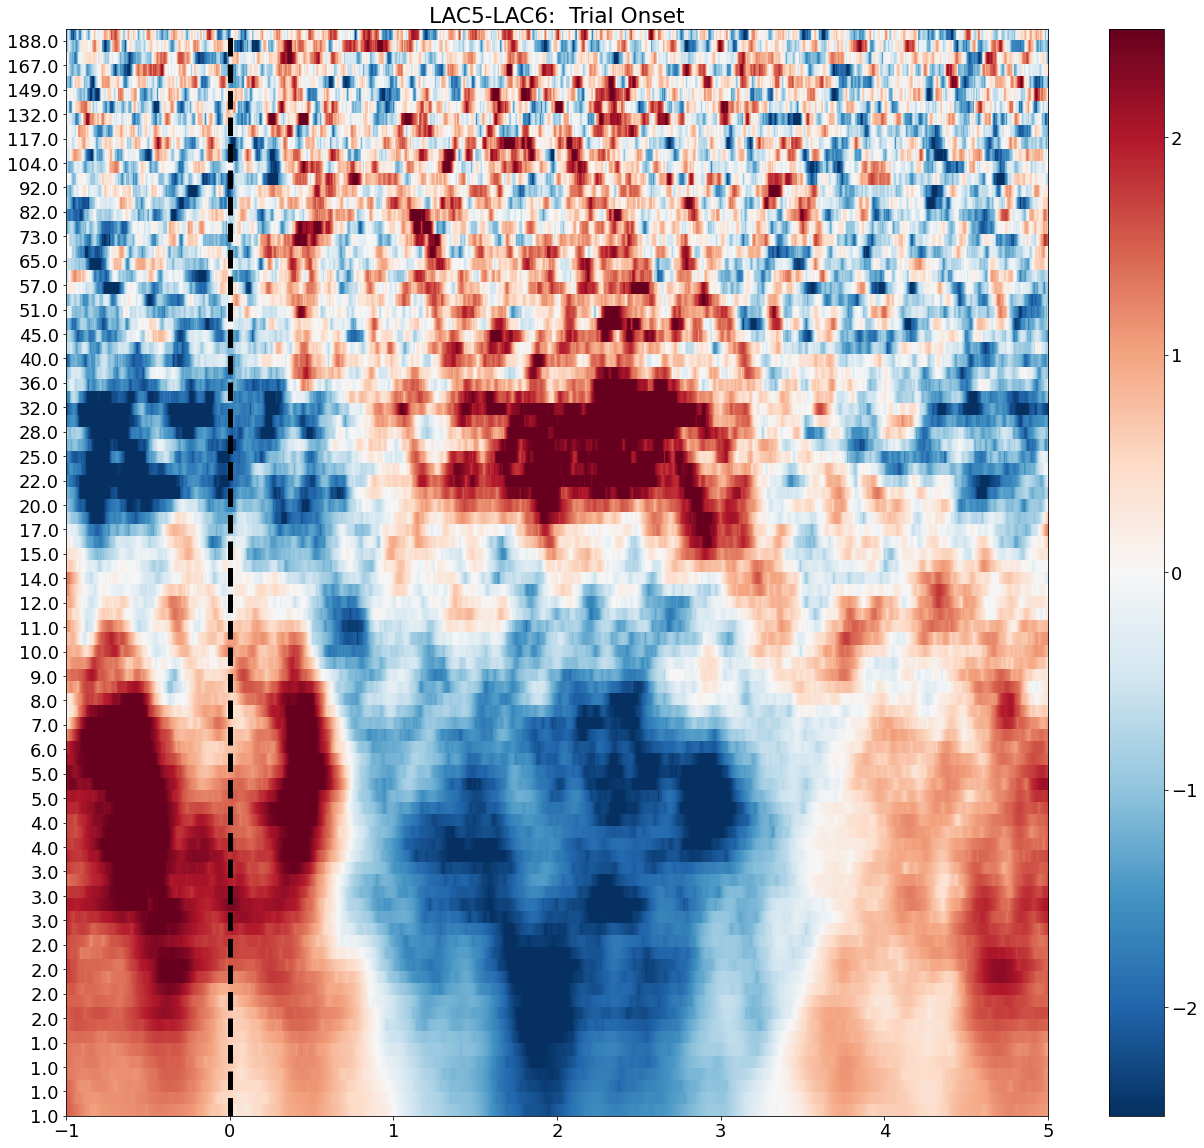

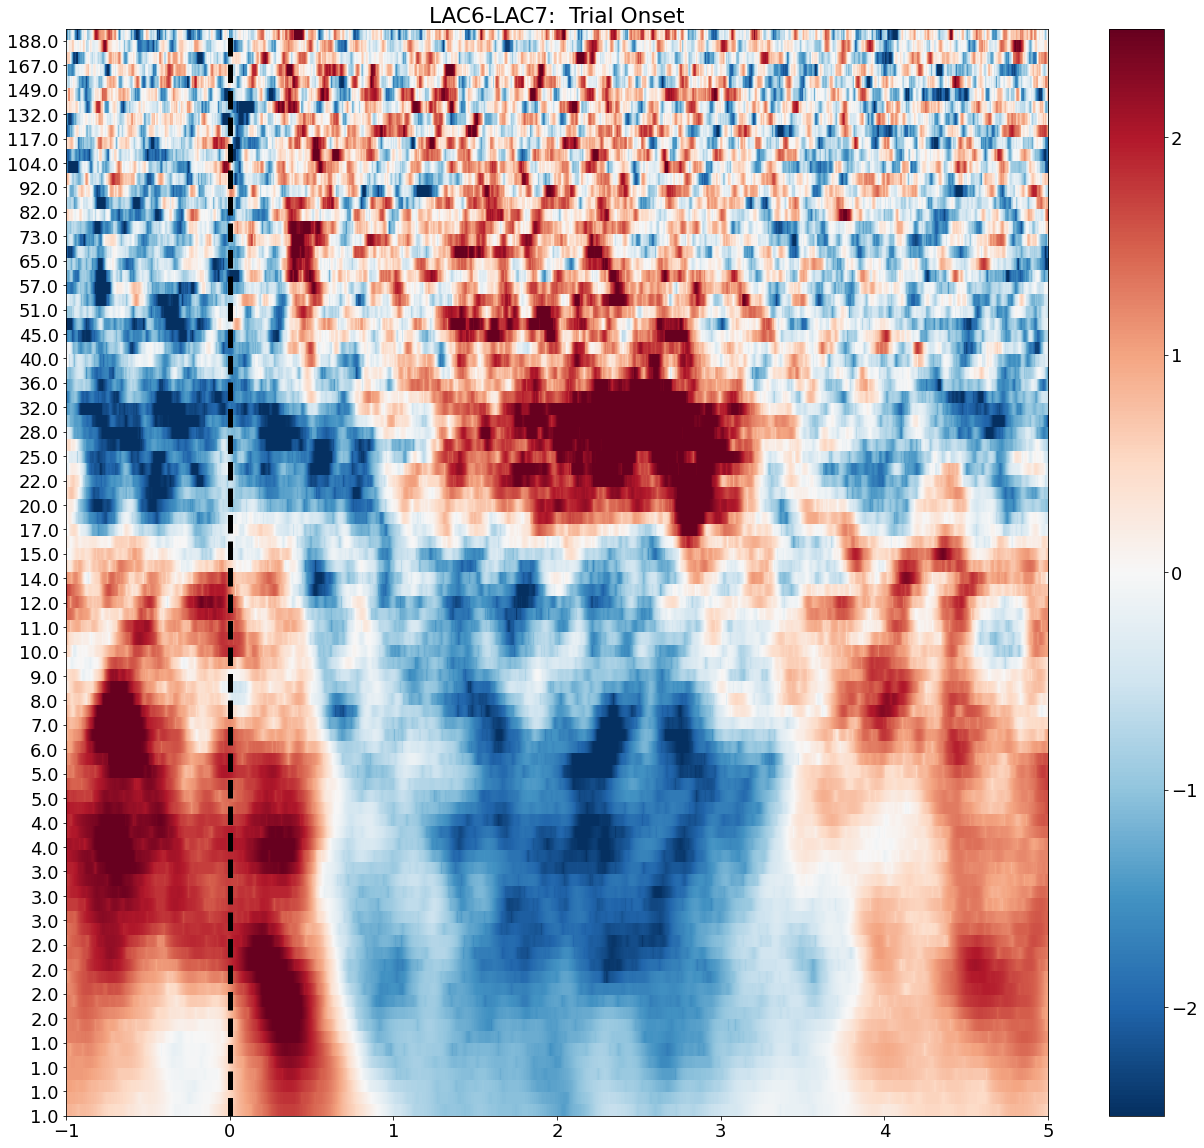

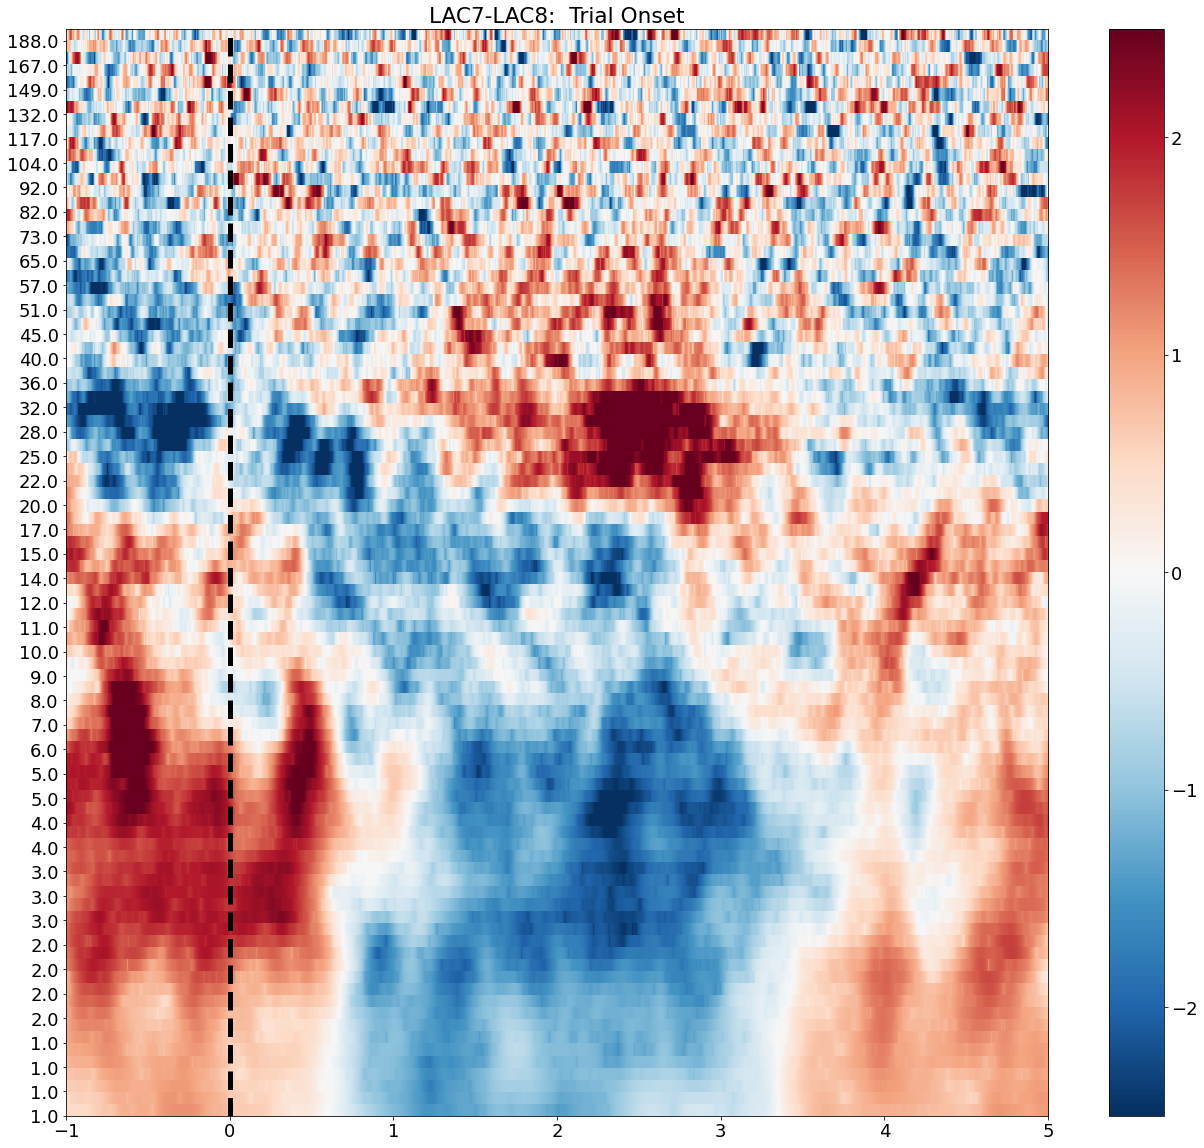

In [99]:
plt.rcParams['figure.figsize'] = [15, 11]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots(figsize = (22, 20))
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -2.5, vmax = 2.5)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs))[::2])
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs)[::2]) 
    i2 = plt.axvline(x=0, color='black', linestyle='--', linewidth = 5)
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()
    
    chix = chix + 1